In [ ]:
! kaggle datasets download mahaveersuryavanshi/datasetb-chilli

Dataset URL: https://www.kaggle.com/datasets/mahaveersuryavanshi/datasetb-chilli
License(s): unknown
 97% 1.02G/1.05G [00:05<00:00, 152MB/s]
100% 1.05G/1.05G [00:06<00:00, 186MB/s]


In [ ]:
!unzip /content/datasetb-chilli.zip

Archive:  /content/datasetb-chilli.zip
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306155808-4.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306160122.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306160153-1.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306160303.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306160345-1.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306160512.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306160558.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306160744-3.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306160836.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306161008.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306161032-1.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306161124-2.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306161124.jpg  
  inflating: DatasetB_split_zip/test/Aphids/IMG20250306161548.jpg

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE

class VisionTransformerFramework_fineTuned:
    def __init__(self, model_name, num_classes=3, device='cuda'):
        self.model_name = model_name
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model = timm.create_model(model_name, pretrained=True)

        in_features = self.model.get_classifier().in_features
        self.model.reset_classifier(num_classes=num_classes)

        self.freeze_layers("backbone")

        head_params = list(self.model.get_classifier().parameters())
        backbone_params = [p for n, p in self.model.named_parameters() if "head" not in n and p.requires_grad]

        self.optimizer = torch.optim.Adam([
            {'params': backbone_params, 'lr': 1e-5},
            {'params': head_params, 'lr': 1e-3}
        ])

        self.criterion = nn.CrossEntropyLoss()
        self.train_losses, self.val_losses = [], []
        self.train_accuracies, self.val_accuracies = [], []
        self.model.to(self.device)

    def freeze_layers(self, freeze_until: str = "all"):
        for name, param in self.model.named_parameters():
            if freeze_until == "all":
                param.requires_grad = False
            elif freeze_until == "none":
                param.requires_grad = True
            elif freeze_until == "backbone":
                param.requires_grad = "head" in name or "fc" in name

    def train(self, train_loader, val_loader, epochs=20, early_stopping_patience=5):
        best_val_loss = float('inf')
        patience_counter = 0
        start_time = time.time()

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=epochs)

        for epoch in range(epochs):
            self.model.train()
            train_loss, correct, total = 0, 0, 0

            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_acc = 100 * correct / total
            val_loss, val_acc = self.evaluate(val_loader)

            self.train_losses.append(train_loss / len(train_loader))
            self.train_accuracies.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered.")
                    break

            scheduler.step()

        print("Training complete in {:.2f}s".format(time.time() - start_time))
        self.plot_training_metrics()

    def evaluate(self, loader):
        self.model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return val_loss / len(loader), 100 * correct / total

    def test(self, test_loader, class_names):
        self.model.eval()
        all_preds, all_labels, all_probs = [], [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                probs = F.softmax(outputs, dim=1)
                _, predicted = torch.max(probs.data, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        print(classification_report(all_labels, all_preds, target_names=class_names))
        self._plot_confusion_matrix(all_labels, all_preds, class_names)
        self._plot_auc_roc(all_labels, all_probs, class_names)
        self._plot_tsne(np.array(all_probs), np.array(all_labels), class_names)
        self._plot_precision_recall_f1(all_labels, all_preds, class_names)

        acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
        print(f"Test Accuracy: {acc:.2f}%")

    def _plot_confusion_matrix(self, labels, preds, class_names):
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.savefig("confusion_matrix.png")
        plt.show()

    def _plot_auc_roc(self, labels, probs, class_names):
        try:
            auc = roc_auc_score(labels, probs, multi_class='ovr')
            print(f"AUC Score: {auc:.4f}")
            for i in range(len(class_names)):
                fpr, tpr, _ = roc_curve(np.array(labels) == i, np.array(probs)[:, i])
                plt.plot(fpr, tpr, label=f'{class_names[i]}')
            plt.title("AUC-ROC Curve")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend()
            plt.tight_layout()
            plt.savefig("auc_roc_curve.png")
            plt.show()
        except ValueError:
            print("ROC curve could not be calculated. Check class distribution.")

    def _plot_tsne(self, features, labels, class_names):
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
        result = tsne.fit_transform(features)
        labels = np.array(labels)
        plt.figure(figsize=(8, 6))
        for i in np.unique(labels):
            idx = labels == i
            plt.scatter(result[idx, 0], result[idx, 1], label=class_names[i], alpha=0.7)
        plt.title("t-SNE of Output Features")
        plt.legend()
        plt.tight_layout()
        plt.savefig("tsne_plot.png")
        plt.show()

    def _plot_precision_recall_f1(self, labels, preds, class_names):
        report = classification_report(labels, preds, target_names=class_names, output_dict=True)
        metrics = ['precision', 'recall', 'f1-score']
        for metric in metrics:
            values = [report[cls][metric] for cls in class_names]
            plt.figure()
            sns.barplot(x=class_names, y=values)
            plt.title(f'{metric.capitalize()} per Class')
            plt.ylim(0, 1)
            plt.tight_layout()
            plt.savefig(f'{metric}_per_class.png')
            plt.show()

    def plot_training_metrics(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.title("Loss Curve")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Acc')
        plt.plot(self.val_accuracies, label='Val Acc')
        plt.title("Accuracy Curve")
        plt.legend()

        plt.tight_layout()
        plt.savefig("training_metrics.png")
        plt.show()

    def visualize_first_layer_filters(self):
        for layer in self.model.modules():
            if isinstance(layer, nn.Conv2d):
                filters = layer.weight.data.clone().cpu()
                break
        else:
            print("No Conv2D layer found.")
            return

        n_filters = min(16, filters.shape[0])
        fig, axs = plt.subplots(1, n_filters, figsize=(20, 5))
        for i in range(n_filters):
            axs[i].imshow(filters[i][0], cmap='gray')
            axs[i].axis('off')
        plt.suptitle("First Conv Layer Filters")
        plt.tight_layout()
        plt.savefig("first_layer_filters.png")
        plt.show()

    def visualize_first_layer_activations(self, image_tensor):
        activation = {}

        def hook_fn(module, input, output):
            activation['act'] = output.detach()

        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d):
                module.register_forward_hook(hook_fn)
                break

        _ = self.model(image_tensor.unsqueeze(0).to(self.device))
        act = activation['act'].squeeze().cpu()
        fig, axs = plt.subplots(1, min(8, act.shape[0]), figsize=(20, 5))
        for i in range(min(8, act.shape[0])):
            axs[i].imshow(act[i], cmap='viridis')
            axs[i].axis('off')
        plt.suptitle("Activations from First Conv Layer")
        plt.tight_layout()
        plt.savefig("first_layer_activations.png")
        plt.show()


In [ ]:
import torch
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Example dataset path (use your own)
train_dataset = datasets.ImageFolder('/content/DatasetB_split_zip/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/DatasetB_split_zip/val', transform=transform)
test_dataset = datasets.ImageFolder('/content/DatasetB_split_zip/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Class names
class_names = train_dataset.classes

In [ ]:
# Replace with your model name and num_classes
model_name = 'vit_base_patch16_224'  # or any of the supported models
num_classes = 3
framework = VisionTransformerFramework_fineTuned(model_name=model_name, num_classes=num_classes)

Epoch [1/30] Train Loss: 23.7086 Acc: 83.17% | Val Loss: 0.2207 Acc: 91.60%
Epoch [2/30] Train Loss: 5.6126 Acc: 97.06% | Val Loss: 0.2338 Acc: 91.86%
Epoch [3/30] Train Loss: 1.3694 Acc: 99.35% | Val Loss: 0.1897 Acc: 93.64%
Epoch [4/30] Train Loss: 0.1812 Acc: 100.00% | Val Loss: 0.1569 Acc: 94.15%
Epoch [5/30] Train Loss: 0.0499 Acc: 100.00% | Val Loss: 0.1578 Acc: 94.40%
Epoch [6/30] Train Loss: 0.0262 Acc: 100.00% | Val Loss: 0.1662 Acc: 94.66%
Epoch [7/30] Train Loss: 0.0194 Acc: 100.00% | Val Loss: 0.1670 Acc: 94.66%
Epoch [8/30] Train Loss: 0.0151 Acc: 100.00% | Val Loss: 0.1666 Acc: 94.66%
Epoch [9/30] Train Loss: 0.0125 Acc: 100.00% | Val Loss: 0.1695 Acc: 94.40%
Early stopping triggered.
Training complete in 787.92s


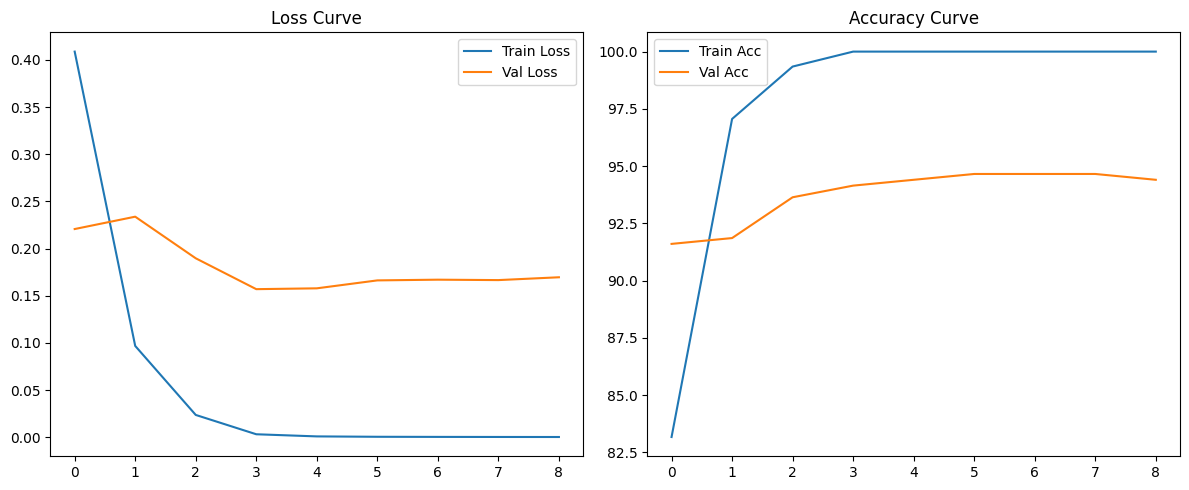

In [ ]:
framework.train(train_loader, val_loader, epochs=30, early_stopping_patience=5)

              precision    recall  f1-score   support

      Aphids       0.98      0.95      0.96       132
     Healthy       0.93      0.98      0.95       132
 Mitesthrips       0.95      0.93      0.94       132

    accuracy                           0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396



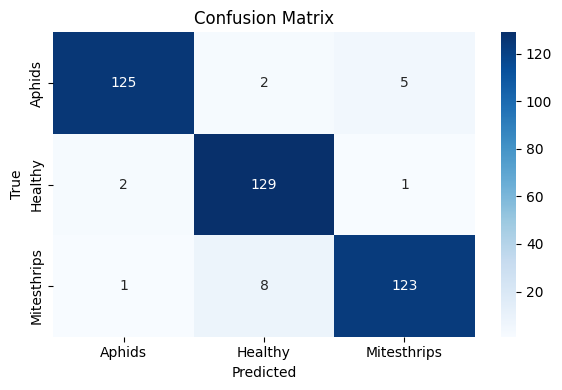

AUC Score: 0.9958


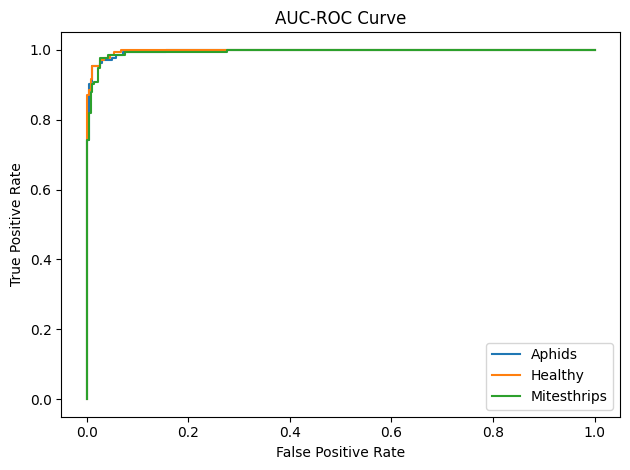

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


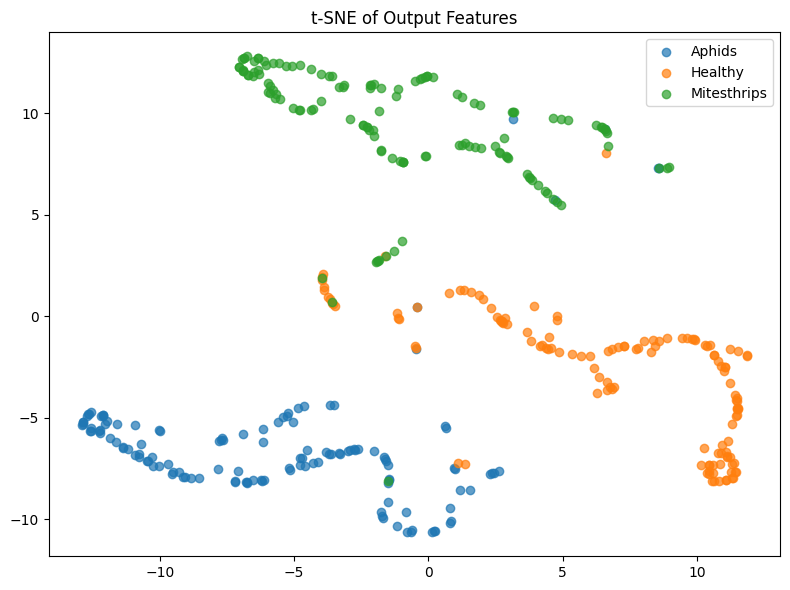

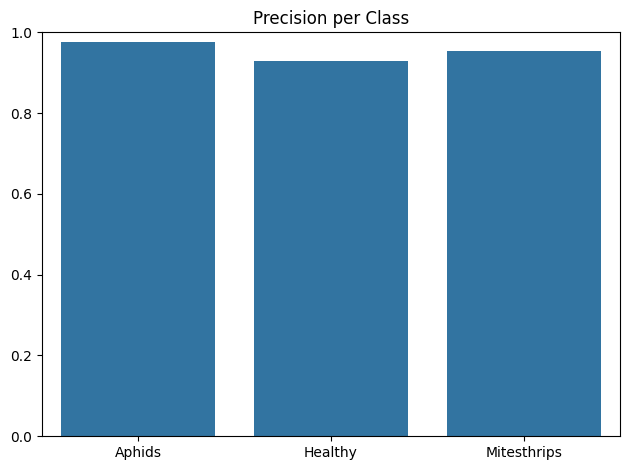

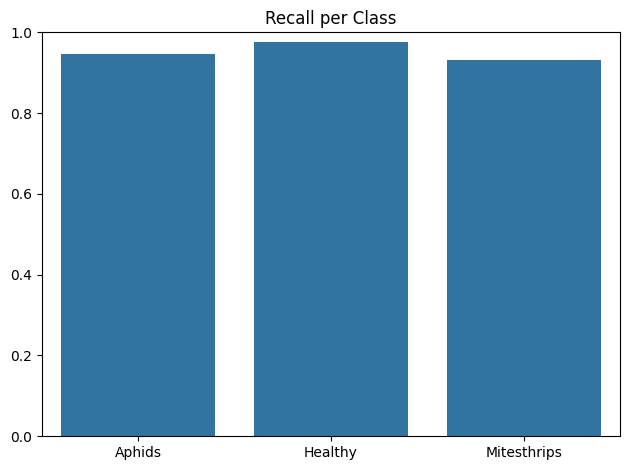

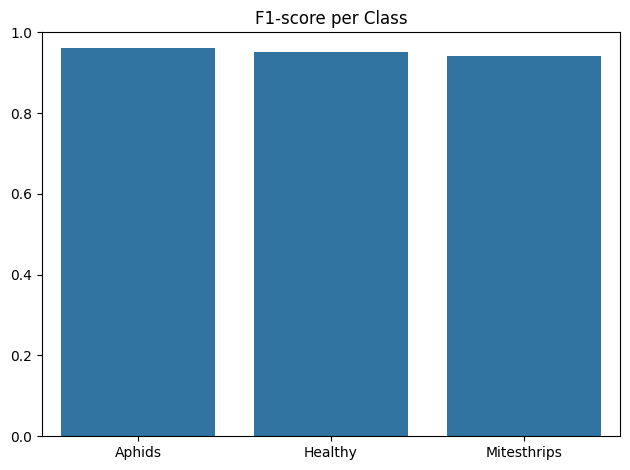

Test Accuracy: 95.20%


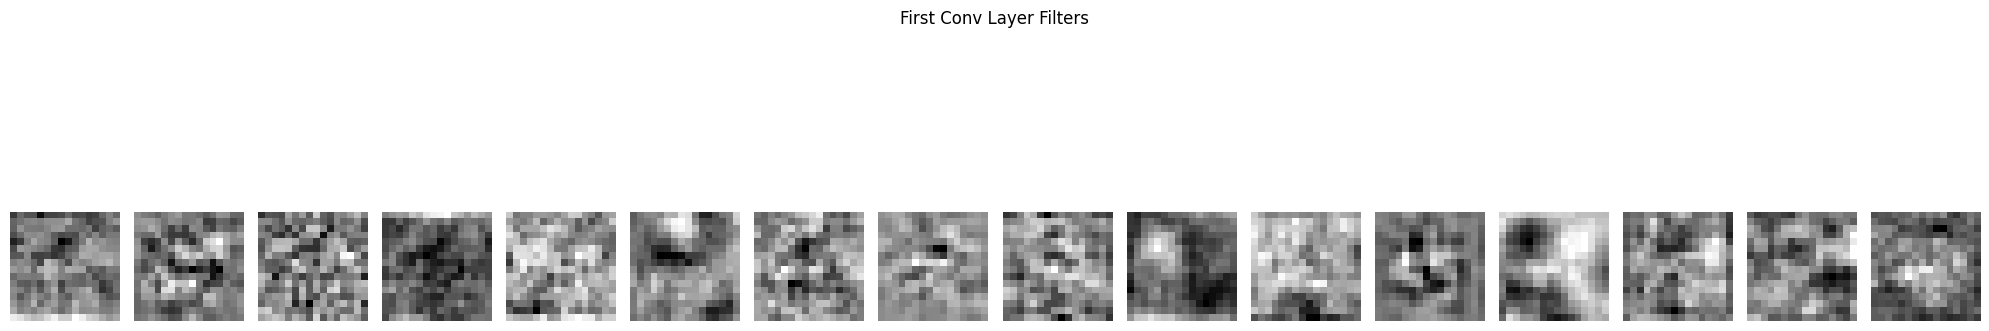

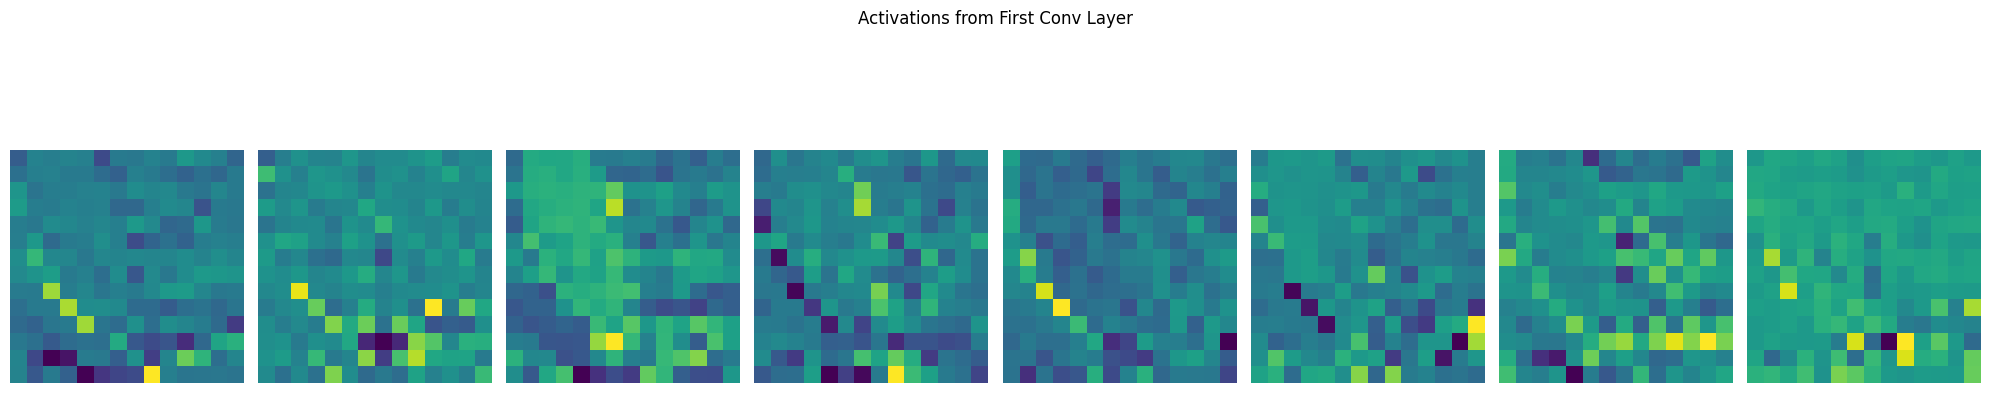

In [ ]:
class_names = ['Aphids', 'Healthy', 'Mitesthrips']  # Modify based on your dataset
framework.test(test_loader, class_names=class_names)

framework.visualize_first_layer_filters()

sample_image, _ = next(iter(test_loader))  # get a batch
framework.visualize_first_layer_activations(sample_image[0])  # visualize first image


In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE

class VisionTransformerFramework_fineTuned_2:
    def __init__(self, model_name, num_classes=3, device='cuda'):
        self.model_name = model_name
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes, drop_rate=0.5)

        self.freeze_layers("none")  # Fine-tune all layers

        head_params = list(self.model.get_classifier().parameters())
        backbone_params = [p for n, p in self.model.named_parameters() if "head" not in n and p.requires_grad]

        self.optimizer = torch.optim.Adam([
            {'params': backbone_params, 'lr': 1e-5, 'weight_decay': 1e-4},
            {'params': head_params, 'lr': 1e-4, 'weight_decay': 1e-4}
        ])

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.train_losses, self.val_losses = [], []
        self.train_accuracies, self.val_accuracies = [], []
        self.model.to(self.device)

    def freeze_layers(self, freeze_until: str = "none"):
        for param in self.model.parameters():
            param.requires_grad = True

    def train(self, train_loader, val_loader, epochs=30, early_stopping_patience=5):
        best_val_loss = float('inf')
        patience_counter = 0
        start_time = time.time()

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=epochs)

        for epoch in range(epochs):
            self.model.train()
            train_loss, correct, total = 0, 0, 0

            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_acc = 100 * correct / total
            val_loss, val_acc = self.evaluate(val_loader)

            self.train_losses.append(train_loss / len(train_loader))
            self.train_accuracies.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered.")
                    break

            scheduler.step()

        print("Training complete in {:.2f}s".format(time.time() - start_time))

    def evaluate(self, loader):
        self.model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return val_loss / len(loader), 100 * correct / total

    def test(self, test_loader, class_names):
        self.model.eval()
        all_preds, all_labels, all_probs = [], [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                probs = F.softmax(outputs, dim=1)
                _, predicted = torch.max(probs.data, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        print(classification_report(all_labels, all_preds, target_names=class_names))
        self._plot_confusion_matrix(all_labels, all_preds, class_names)
        self._plot_auc_roc(all_labels, all_probs, class_names)
        self._plot_tsne(np.array(all_probs), np.array(all_labels), class_names)
        self._plot_precision_recall_f1(all_labels, all_preds, class_names)

        acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
        print(f"Test Accuracy: {acc:.2f}%")

    def _plot_confusion_matrix(self, labels, preds, class_names):
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    def _plot_auc_roc(self, labels, probs, class_names):
        labels = np.array(labels)
        probs = np.array(probs)
        try:
            auc = roc_auc_score(labels, probs, multi_class='ovr')
            print(f"AUC Score: {auc:.4f}")
            for i in range(len(class_names)):
                fpr, tpr, _ = roc_curve(labels == i, probs[:, i])
                plt.plot(fpr, tpr, label=f'{class_names[i]}')
            plt.title("AUC-ROC Curve")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend()
            plt.show()
        except ValueError:
            print("ROC curve could not be calculated. Check class distribution.")

    def _plot_tsne(self, features, labels, class_names):
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
        result = tsne.fit_transform(features)
        labels = np.array(labels)
        plt.figure(figsize=(8, 6))
        for i in np.unique(labels):
            idx = labels == i
            plt.scatter(result[idx, 0], result[idx, 1], label=class_names[i], alpha=0.7)
        plt.title("t-SNE of Output Features")
        plt.legend()
        plt.show()

    def _plot_precision_recall_f1(self, labels, preds, class_names):
        report = classification_report(labels, preds, target_names=class_names, output_dict=True)
        metrics = ['precision', 'recall', 'f1-score']
        for metric in metrics:
            values = [report[cls][metric] for cls in class_names]
            plt.figure()
            sns.barplot(x=class_names, y=values)
            plt.title(f'{metric.capitalize()} per Class')
            plt.ylim(0, 1)
            plt.show()

    def plot_training_metrics(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.title("Loss Curve")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Acc')
        plt.plot(self.val_accuracies, label='Val Acc')
        plt.title("Accuracy Curve")
        plt.legend()
        plt.show()

    def visualize_first_layer_filters(self):
        for layer in self.model.modules():
            if isinstance(layer, nn.Conv2d):
                filters = layer.weight.data.clone().cpu()
                break
        else:
            print("No Conv2D layer found.")
            return

        n_filters = min(16, filters.shape[0])
        fig, axs = plt.subplots(1, n_filters, figsize=(20, 5))
        for i in range(n_filters):
            axs[i].imshow(filters[i][0], cmap='gray')
            axs[i].axis('off')
        plt.suptitle("First Conv Layer Filters")
        plt.show()

    def visualize_first_layer_activations(self, image_tensor):
        activation = {}

        def hook_fn(module, input, output):
            activation['act'] = output.detach()

        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d):
                module.register_forward_hook(hook_fn)
                break

        _ = self.model(image_tensor.unsqueeze(0).to(self.device))
        act = activation['act'].squeeze().cpu()
        fig, axs = plt.subplots(1, min(8, act.shape[0]), figsize=(20, 5))
        for i in range(min(8, act.shape[0])):
            axs[i].imshow(act[i], cmap='viridis')
            axs[i].axis('off')
        plt.suptitle("Activations from First Conv Layer")
        plt.show()


In [ ]:
# Replace with your model name and num_classes
model_name = 'vit_base_patch16_224'  # or any of the supported models
num_classes = 3
framework_2 = VisionTransformerFramework_fineTuned_2(model_name=model_name, num_classes=num_classes)

In [ ]:
framework_2.train(train_loader, val_loader, epochs=30, early_stopping_patience=5)

Epoch [1/30] Train Loss: 44.8347 Acc: 70.97% | Val Loss: 0.5064 Acc: 89.82%
Epoch [2/30] Train Loss: 26.2899 Acc: 92.48% | Val Loss: 0.4433 Acc: 93.13%
Epoch [3/30] Train Loss: 21.5031 Acc: 97.82% | Val Loss: 0.4379 Acc: 93.13%
Epoch [4/30] Train Loss: 19.6123 Acc: 98.91% | Val Loss: 0.4271 Acc: 92.88%
Epoch [5/30] Train Loss: 18.1857 Acc: 100.00% | Val Loss: 0.4096 Acc: 93.89%
Epoch [6/30] Train Loss: 17.8894 Acc: 100.00% | Val Loss: 0.4085 Acc: 93.89%
Epoch [7/30] Train Loss: 17.6816 Acc: 100.00% | Val Loss: 0.4197 Acc: 93.38%
Epoch [8/30] Train Loss: 17.5978 Acc: 100.00% | Val Loss: 0.4127 Acc: 93.64%
Epoch [9/30] Train Loss: 17.4807 Acc: 100.00% | Val Loss: 0.4141 Acc: 93.89%
Epoch [10/30] Train Loss: 17.4264 Acc: 100.00% | Val Loss: 0.4108 Acc: 94.15%
Epoch [11/30] Train Loss: 17.3650 Acc: 100.00% | Val Loss: 0.4079 Acc: 93.64%
Epoch [12/30] Train Loss: 17.3180 Acc: 100.00% | Val Loss: 0.4155 Acc: 93.13%
Epoch [13/30] Train Loss: 17.2830 Acc: 100.00% | Val Loss: 0.4097 Acc: 93.89%

              precision    recall  f1-score   support

      Aphids       0.98      0.95      0.96       132
     Healthy       0.93      0.98      0.95       132
 Mitesthrips       0.95      0.93      0.94       132

    accuracy                           0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396



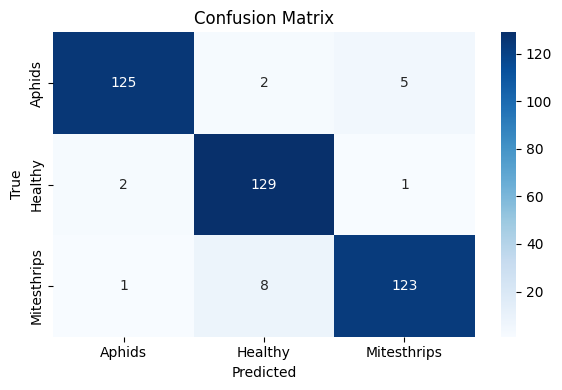

AUC Score: 0.9958


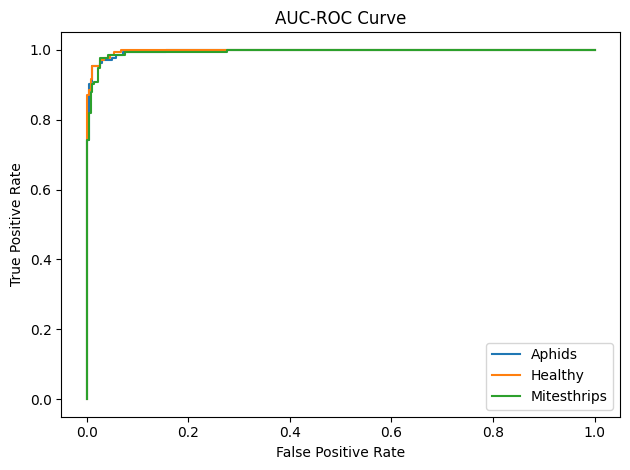

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


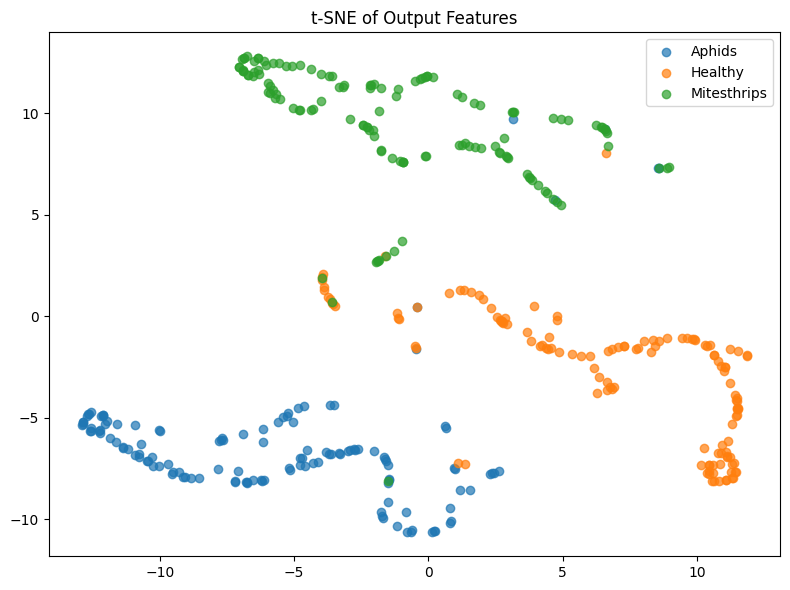

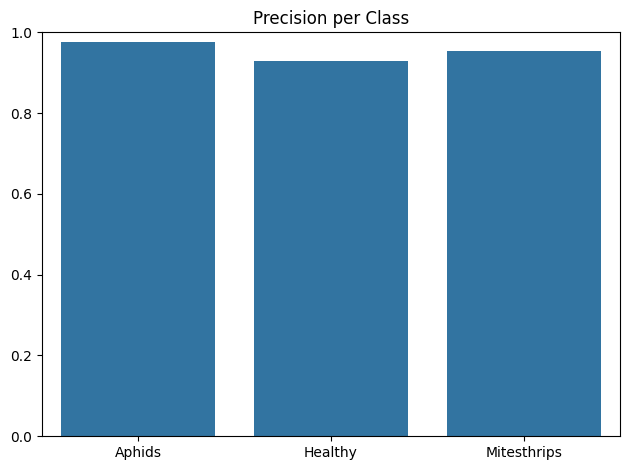

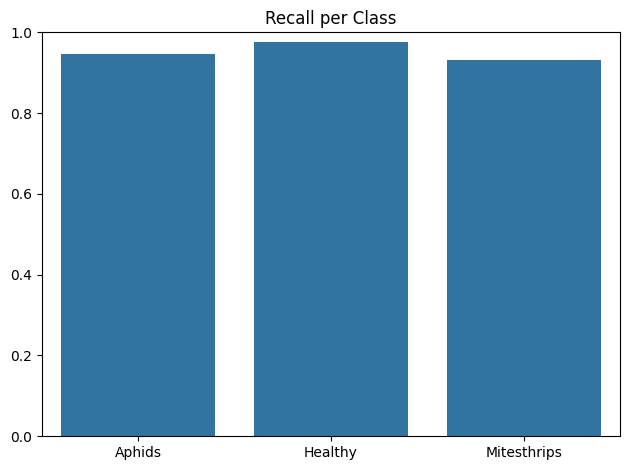

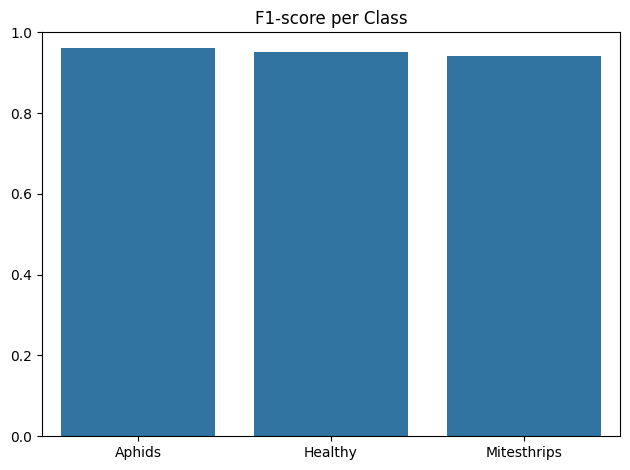

Test Accuracy: 95.20%


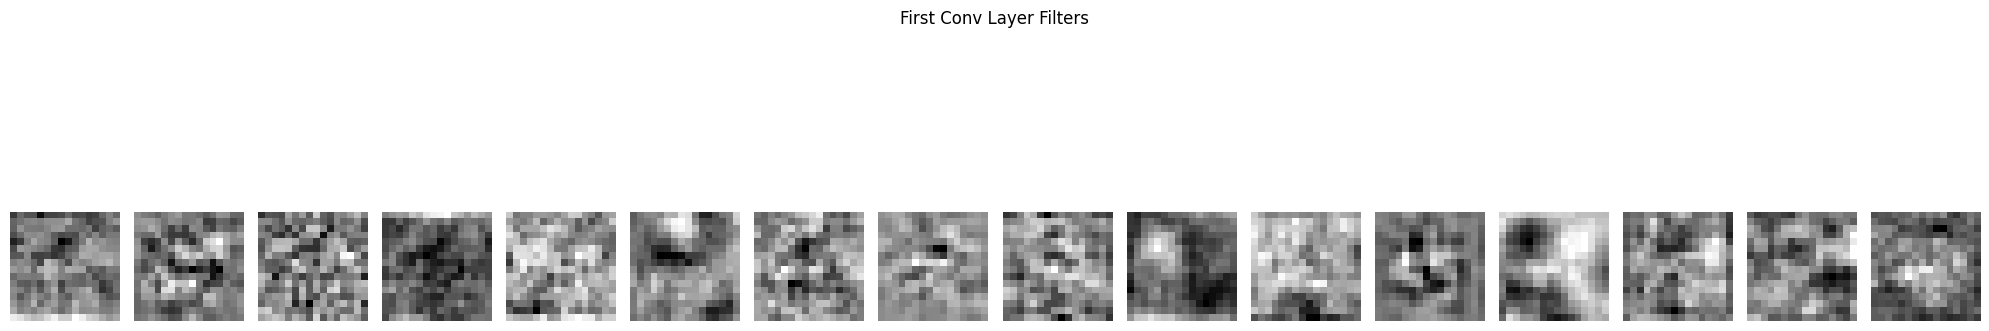

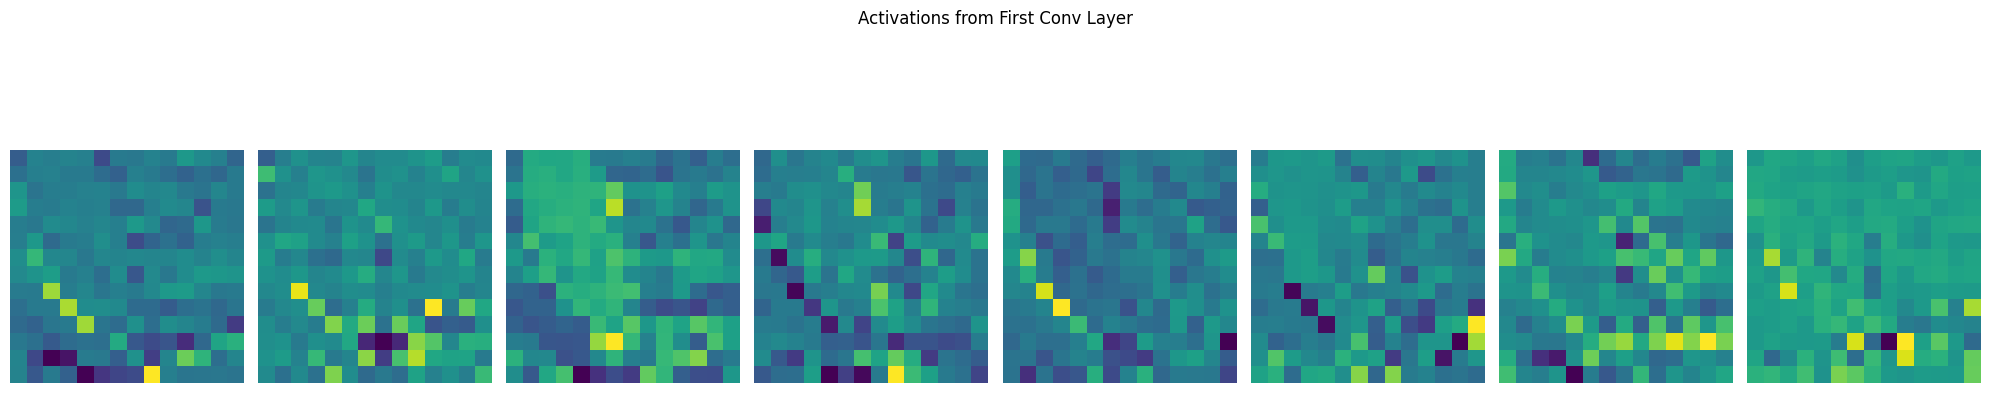

In [ ]:
class_names = ['Aphids', 'Healthy', 'Mitesthrips']  # Modify based on your dataset
framework.test(test_loader, class_names=class_names)

framework.visualize_first_layer_filters()

sample_image, _ = next(iter(test_loader))  # get a batch
framework.visualize_first_layer_activations(sample_image[0])  # visualize first image

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE

class VisionTransformerFramework_fineTuned1:
    def __init__(self, model_name, num_classes=3, device='cuda'):
        self.model_name = model_name
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model = timm.create_model(model_name, pretrained=True)

        in_features = self.model.get_classifier().in_features
        self.model.reset_classifier(num_classes=num_classes)

        trainable = [name for name, p in self.model.named_parameters() if p.requires_grad]
        if not trainable:
          raise RuntimeError("No trainable parameters found. Check your freeze_layers logic.")
        else:
          print(f"Trainable params: {len(trainable)}")

        # self.freeze_layers("custom",9)
        self.freeze_layers("custom",5)
        # self.freeze_layers("custom",4)
        # self.freeze_layers("custom",7)
        # self.freeze_layers("head_only")

        head_params = list(self.model.get_classifier().parameters())
        backbone_params = [p for n, p in self.model.named_parameters() if "head" not in n and p.requires_grad]

        self.optimizer = torch.optim.Adam([
            {'params': backbone_params, 'lr': 1e-5},
            {'params': head_params, 'lr': 1e-3}
        ])

        self.criterion = nn.CrossEntropyLoss()
        self.train_losses, self.val_losses = [], []
        self.train_accuracies, self.val_accuracies = [], []
        self.model.to(self.device)
    def freeze_layers(self, strategy: str = "all", unfreeze_from_block: int = None):
      """
      strategy: "all", "none", "head_only", "custom"
      unfreeze_from_block: for "custom", unfreeze from a certain block number (e.g., 9 means last 3 blocks in ViT-B/16)
      """
      if strategy == "none":
        # Unfreeze all
        for param in self.model.parameters():
            param.requires_grad = True

      elif strategy == "all":
        # Freeze all
        for param in self.model.parameters():
            param.requires_grad = False


      elif strategy == "head_only":
        for name, param in self.model.named_parameters():
            if "head" in name or "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

      elif strategy == "custom":
        for name, param in self.model.named_parameters():
            param.requires_grad = False  # Default to frozen

            if "head" in name or "fc" in name:
                param.requires_grad = True  # Always unfreeze head

            if unfreeze_from_block is not None:
                # Example: unfreeze blocks.9 to blocks.11
                for i in range(unfreeze_from_block, 12):  # assuming 12 transformer blocks
                    if f"blocks.{i}" in name:
                        param.requires_grad = True

                # Also unfreeze norm/pre_logits layers if they exist
                if any(x in name for x in ["norm", "pre_logits"]):
                    param.requires_grad = True


    def train(self, train_loader, val_loader, epochs=20, early_stopping_patience=5):
        best_val_loss = float('inf')
        patience_counter = 0
        start_time = time.time()

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=epochs)

        for epoch in range(epochs):
            self.model.train()
            train_loss, correct, total = 0, 0, 0

            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_acc = 100 * correct / total
            val_loss, val_acc = self.evaluate(val_loader)

            self.train_losses.append(train_loss / len(train_loader))
            self.train_accuracies.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered.")
                    break

            scheduler.step()

        print("Training complete in {:.2f}s".format(time.time() - start_time))
        self.plot_training_metrics()

    def evaluate(self, loader):
        self.model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return val_loss / len(loader), 100 * correct / total

    def test(self, test_loader, class_names):
        self.model.eval()
        all_preds, all_labels, all_probs = [], [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                probs = F.softmax(outputs, dim=1)
                _, predicted = torch.max(probs.data, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        print(classification_report(all_labels, all_preds, target_names=class_names))
        self._plot_confusion_matrix(all_labels, all_preds, class_names)
        self._plot_auc_roc(all_labels, all_probs, class_names)
        self._plot_tsne(np.array(all_probs), np.array(all_labels), class_names)
        self._plot_precision_recall_f1(all_labels, all_preds, class_names)

        acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
        print(f"Test Accuracy: {acc:.2f}%")

    def _plot_confusion_matrix(self, labels, preds, class_names):
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.savefig("confusion_matrix.png")
        plt.show()

    def _plot_auc_roc(self, labels, probs, class_names):
        try:
            auc = roc_auc_score(labels, probs, multi_class='ovr')
            print(f"AUC Score: {auc:.4f}")
            for i in range(len(class_names)):
                fpr, tpr, _ = roc_curve(np.array(labels) == i, np.array(probs)[:, i])
                plt.plot(fpr, tpr, label=f'{class_names[i]}')
            plt.title("AUC-ROC Curve")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend()
            plt.tight_layout()
            plt.savefig("auc_roc_curve.png")
            plt.show()
        except ValueError:
            print("ROC curve could not be calculated. Check class distribution.")

    def _plot_tsne(self, features, labels, class_names):
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
        result = tsne.fit_transform(features)
        labels = np.array(labels)
        plt.figure(figsize=(8, 6))
        for i in np.unique(labels):
            idx = labels == i
            plt.scatter(result[idx, 0], result[idx, 1], label=class_names[i], alpha=0.7)
        plt.title("t-SNE of Output Features")
        plt.legend()
        plt.tight_layout()
        plt.savefig("tsne_plot.png")
        plt.show()

    def _plot_precision_recall_f1(self, labels, preds, class_names):
        report = classification_report(labels, preds, target_names=class_names, output_dict=True)
        metrics = ['precision', 'recall', 'f1-score']
        for metric in metrics:
            values = [report[cls][metric] for cls in class_names]
            plt.figure()
            sns.barplot(x=class_names, y=values)
            plt.title(f'{metric.capitalize()} per Class')
            plt.ylim(0, 1)
            plt.tight_layout()
            plt.savefig(f'{metric}_per_class.png')
            plt.show()

    def plot_training_metrics(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.title("Loss Curve")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Acc')
        plt.plot(self.val_accuracies, label='Val Acc')
        plt.title("Accuracy Curve")
        plt.legend()

        plt.tight_layout()
        plt.savefig("training_metrics.png")
        plt.show()

    def visualize_first_layer_filters(self):
        for layer in self.model.modules():
            if isinstance(layer, nn.Conv2d):
                filters = layer.weight.data.clone().cpu()
                break
        else:
            print("No Conv2D layer found.")
            return

        n_filters = min(16, filters.shape[0])
        fig, axs = plt.subplots(1, n_filters, figsize=(20, 5))
        for i in range(n_filters):
            axs[i].imshow(filters[i][0], cmap='gray')
            axs[i].axis('off')
        plt.suptitle("First Conv Layer Filters")
        plt.tight_layout()
        plt.savefig("first_layer_filters.png")
        plt.show()

    def visualize_first_layer_activations(self, image_tensor):
        activation = {}

        def hook_fn(module, input, output):
            activation['act'] = output.detach()

        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d):
                module.register_forward_hook(hook_fn)
                break

        _ = self.model(image_tensor.unsqueeze(0).to(self.device))
        act = activation['act'].squeeze().cpu()
        fig, axs = plt.subplots(1, min(8, act.shape[0]), figsize=(20, 5))
        for i in range(min(8, act.shape[0])):
            axs[i].imshow(act[i], cmap='viridis')
            axs[i].axis('off')
        plt.suptitle("Activations from First Conv Layer")
        plt.tight_layout()
        plt.savefig("first_layer_activations.png")
        plt.show()


**Unfreeze last 3 transformer blocks (blocks.9, blocks.10, blocks.11)
**

In [ ]:
# Replace with your model name and num_classes
model_name = 'vit_base_patch16_224'  # or any of the supported models
num_classes = 3
framework = VisionTransformerFramework_fineTuned1(model_name=model_name, num_classes=num_classes)

Trainable params: 152


Epoch [1/30] Train Loss: 21.6123 Acc: 85.19% | Val Loss: 0.1985 Acc: 91.86%
Epoch [2/30] Train Loss: 3.8393 Acc: 97.49% | Val Loss: 0.1300 Acc: 94.91%
Epoch [3/30] Train Loss: 0.4745 Acc: 99.95% | Val Loss: 0.1700 Acc: 94.91%
Epoch [4/30] Train Loss: 0.0840 Acc: 100.00% | Val Loss: 0.1614 Acc: 94.91%
Epoch [5/30] Train Loss: 0.0250 Acc: 100.00% | Val Loss: 0.1571 Acc: 95.17%
Epoch [6/30] Train Loss: 0.0136 Acc: 100.00% | Val Loss: 0.1667 Acc: 95.42%
Epoch [7/30] Train Loss: 0.0102 Acc: 100.00% | Val Loss: 0.1678 Acc: 95.17%
Early stopping triggered.
Training complete in 640.86s


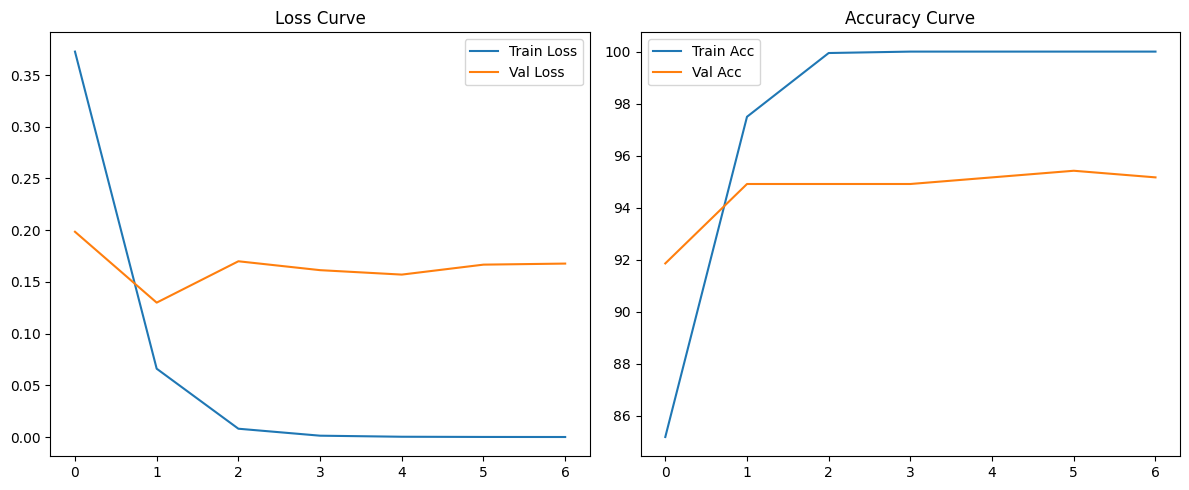

In [ ]:
framework.train(train_loader, val_loader, epochs=30, early_stopping_patience=5)

              precision    recall  f1-score   support

      Aphids       0.95      0.95      0.95       132
     Healthy       0.90      0.98      0.93       132
 Mitesthrips       0.97      0.88      0.92       132

    accuracy                           0.94       396
   macro avg       0.94      0.94      0.94       396
weighted avg       0.94      0.94      0.94       396



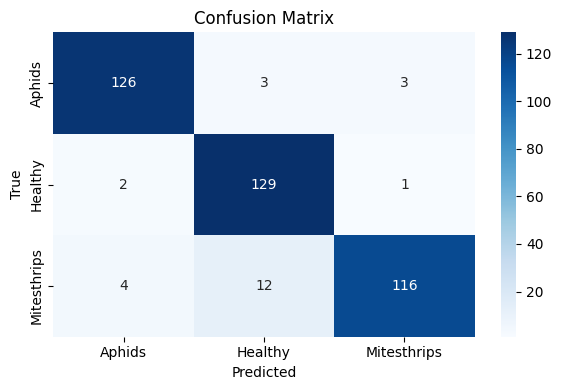

AUC Score: 0.9953


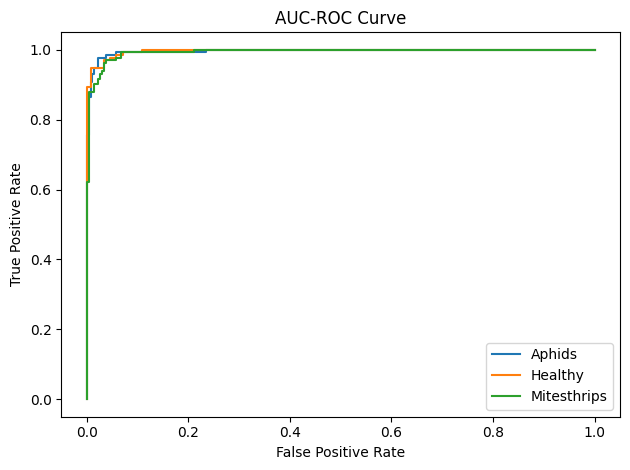

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


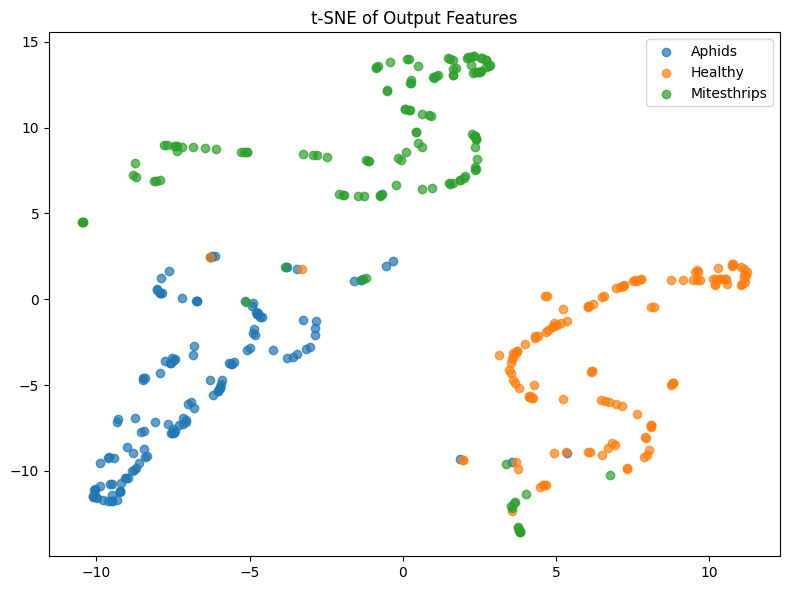

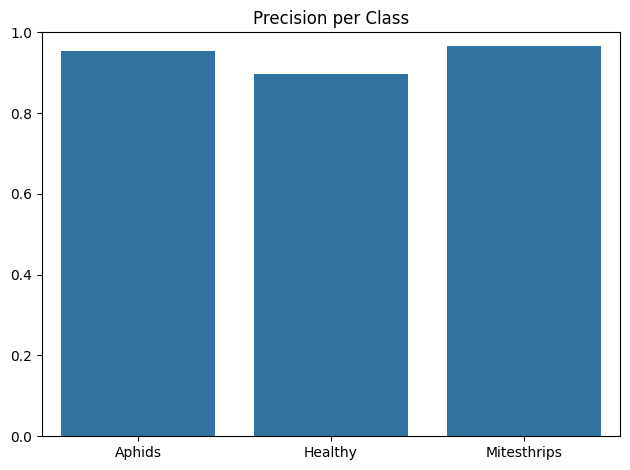

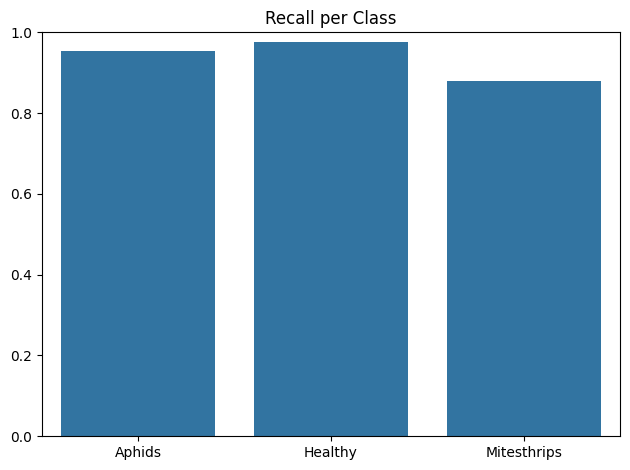

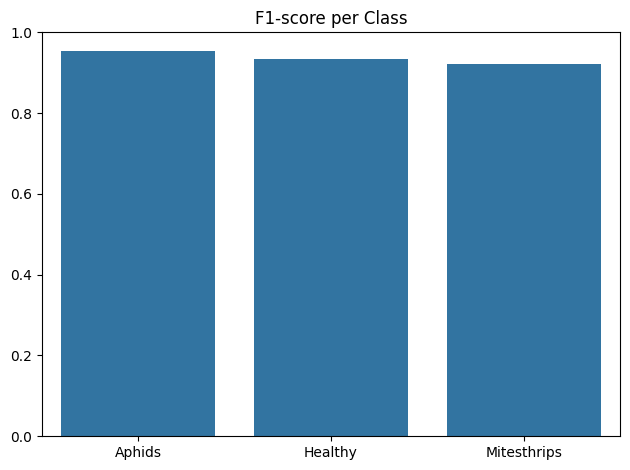

Test Accuracy: 93.69%


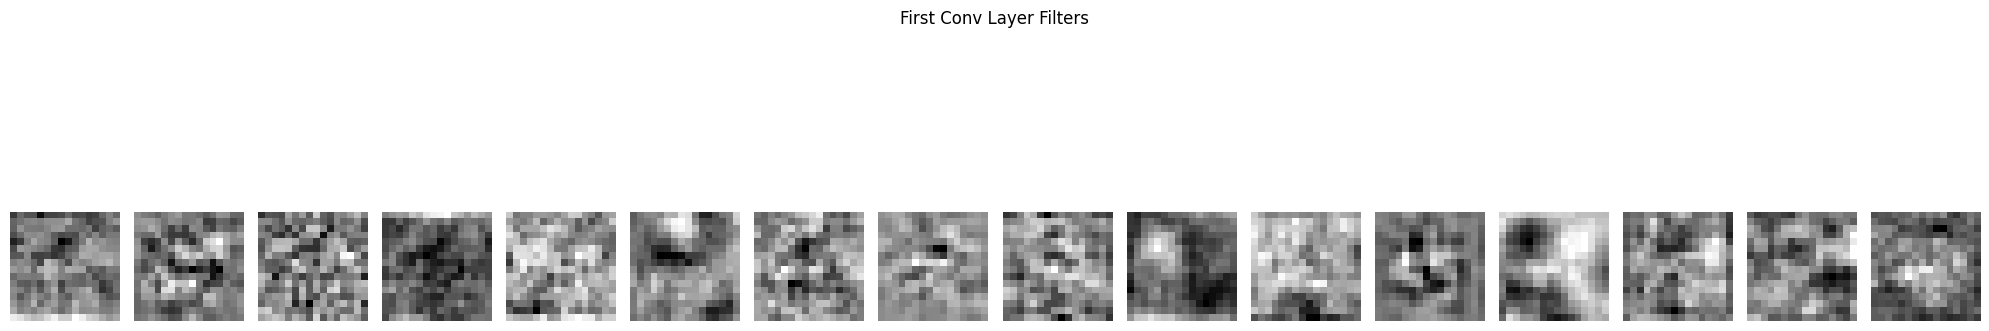

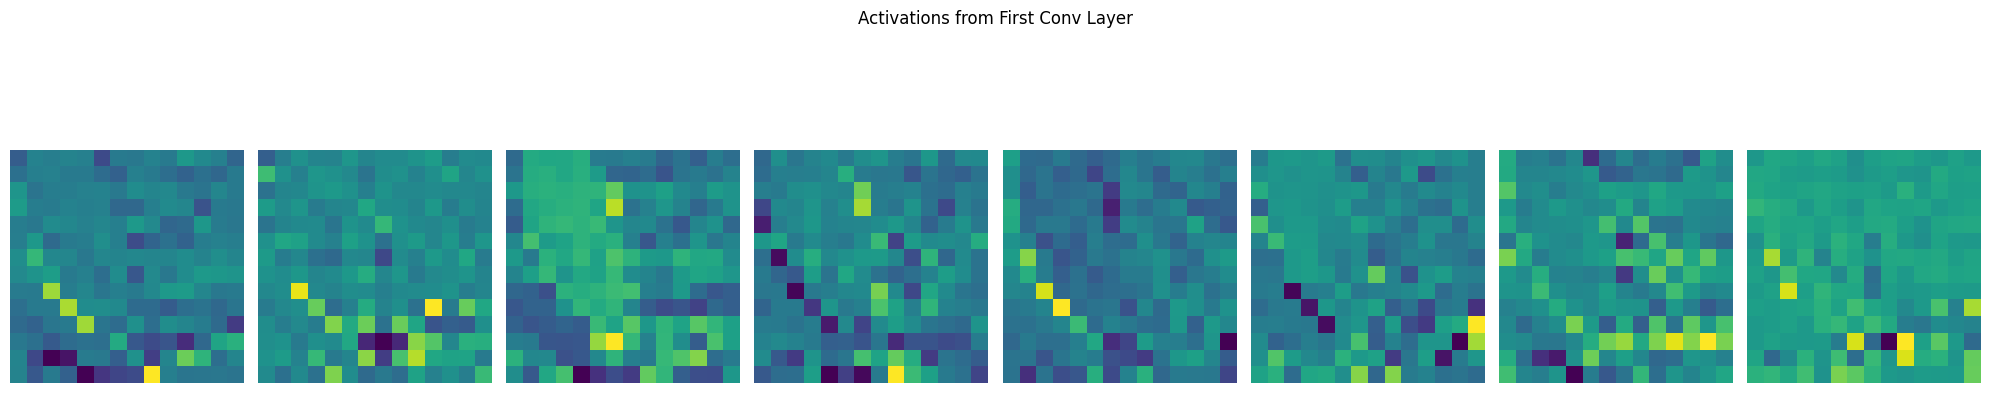

In [ ]:
class_names = ['Aphids', 'Healthy', 'Mitesthrips']  # Modify based on your dataset
framework.test(test_loader, class_names=class_names)

framework.visualize_first_layer_filters()

sample_image, _ = next(iter(test_loader))  # get a batch
framework.visualize_first_layer_activations(sample_image[0])  # visualize first image


**Unfreeze last 7 transformer blocks**

In [ ]:
# Replace with your model name and num_classes
model_name = 'vit_base_patch16_224'  # or any of the supported models
num_classes = 3
framework_4 = VisionTransformerFramework_fineTuned1(model_name=model_name, num_classes=num_classes)

Trainable params: 152


Epoch [1/30] Train Loss: 24.1953 Acc: 83.33% | Val Loss: 0.3923 Acc: 86.77%
Epoch [2/30] Train Loss: 5.6753 Acc: 96.57% | Val Loss: 0.2057 Acc: 91.86%
Epoch [3/30] Train Loss: 1.7125 Acc: 98.86% | Val Loss: 0.1374 Acc: 93.89%
Epoch [4/30] Train Loss: 0.1447 Acc: 99.95% | Val Loss: 0.1711 Acc: 93.64%
Epoch [5/30] Train Loss: 0.0391 Acc: 100.00% | Val Loss: 0.1562 Acc: 94.40%
Epoch [6/30] Train Loss: 0.0121 Acc: 100.00% | Val Loss: 0.1584 Acc: 94.66%
Epoch [7/30] Train Loss: 0.0087 Acc: 100.00% | Val Loss: 0.1628 Acc: 94.91%
Epoch [8/30] Train Loss: 0.0068 Acc: 100.00% | Val Loss: 0.1654 Acc: 94.91%
Early stopping triggered.
Training complete in 756.75s


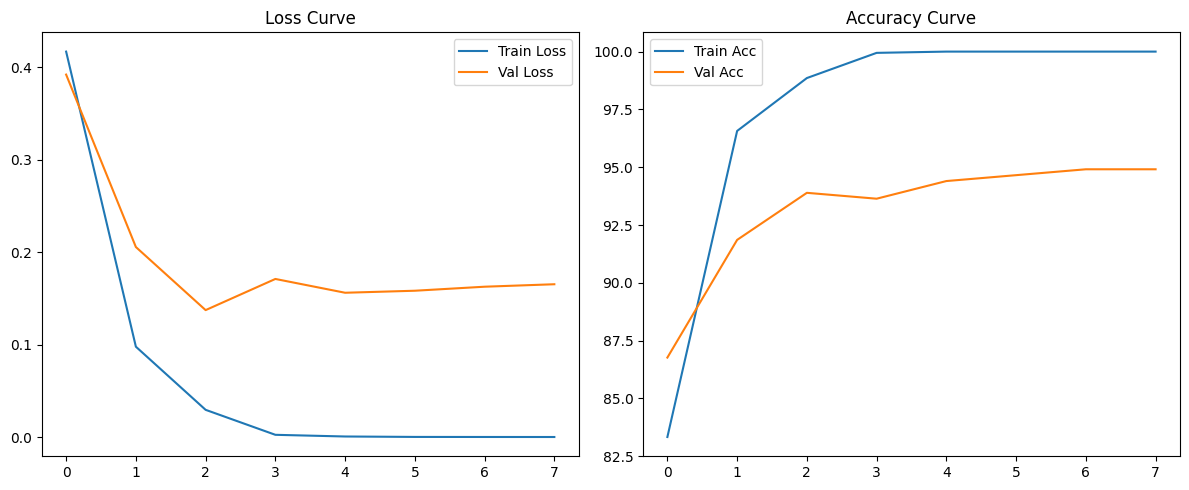

In [ ]:
framework_4.train(train_loader, val_loader, epochs=30, early_stopping_patience=5)

              precision    recall  f1-score   support

      Aphids       0.98      0.97      0.98       132
     Healthy       0.94      0.97      0.96       132
 Mitesthrips       0.95      0.94      0.95       132

    accuracy                           0.96       396
   macro avg       0.96      0.96      0.96       396
weighted avg       0.96      0.96      0.96       396



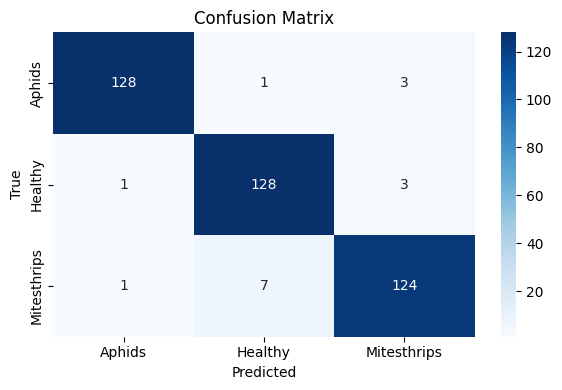

AUC Score: 0.9960


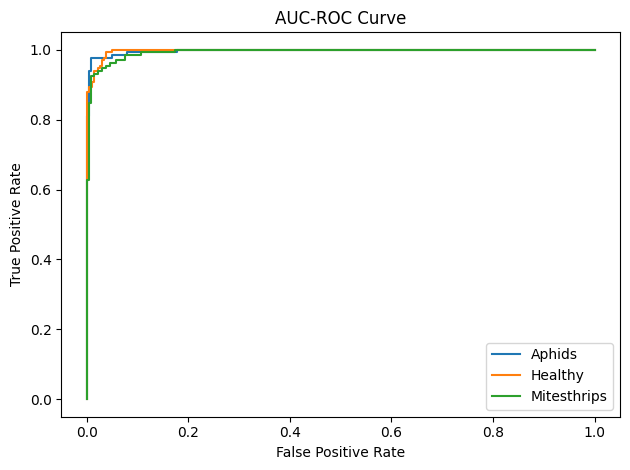

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


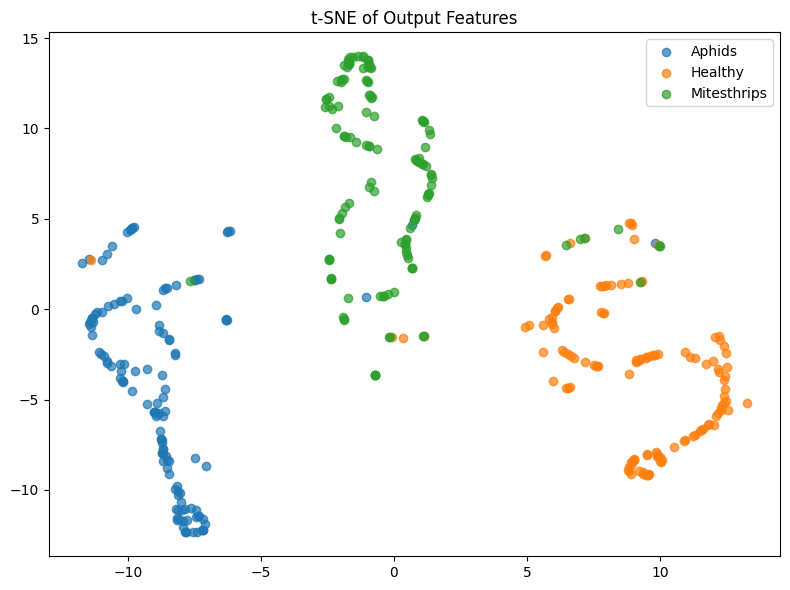

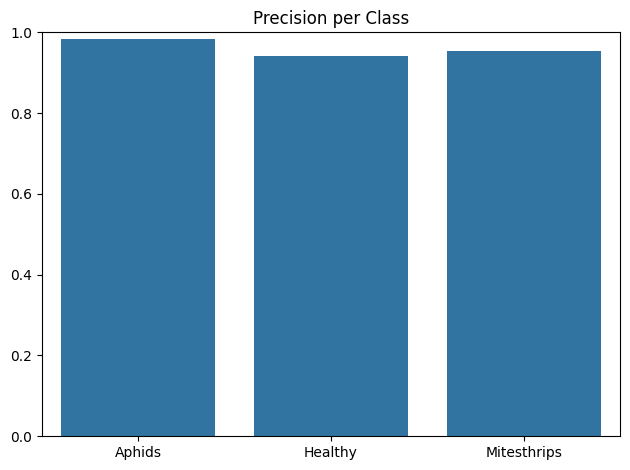

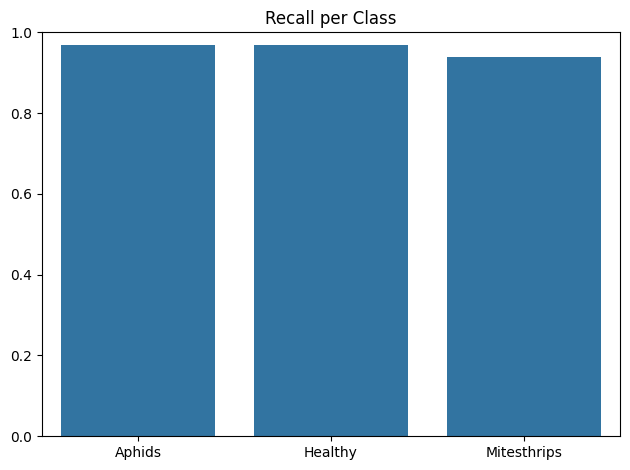

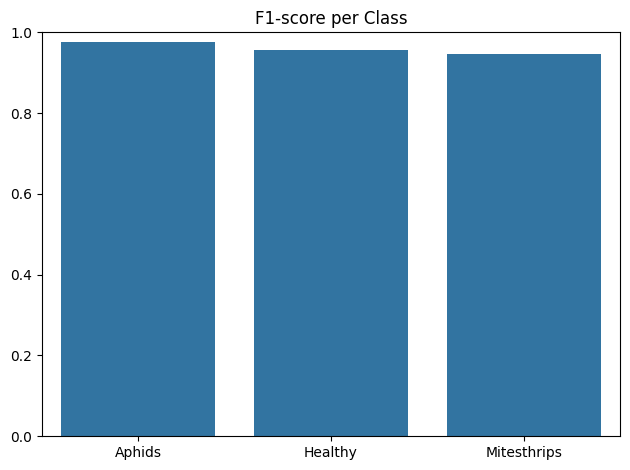

Test Accuracy: 95.96%


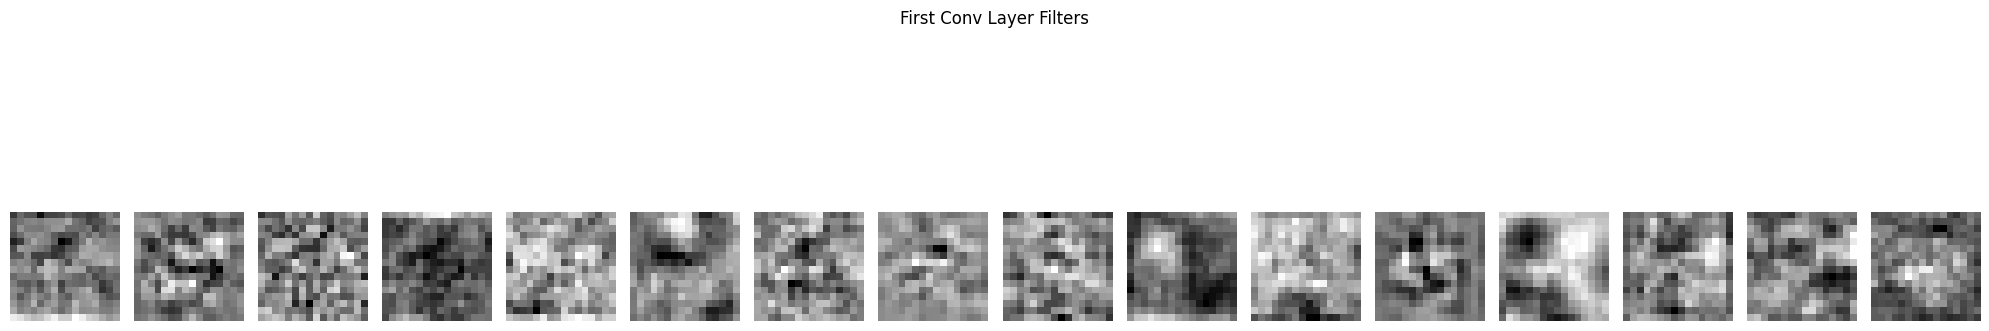

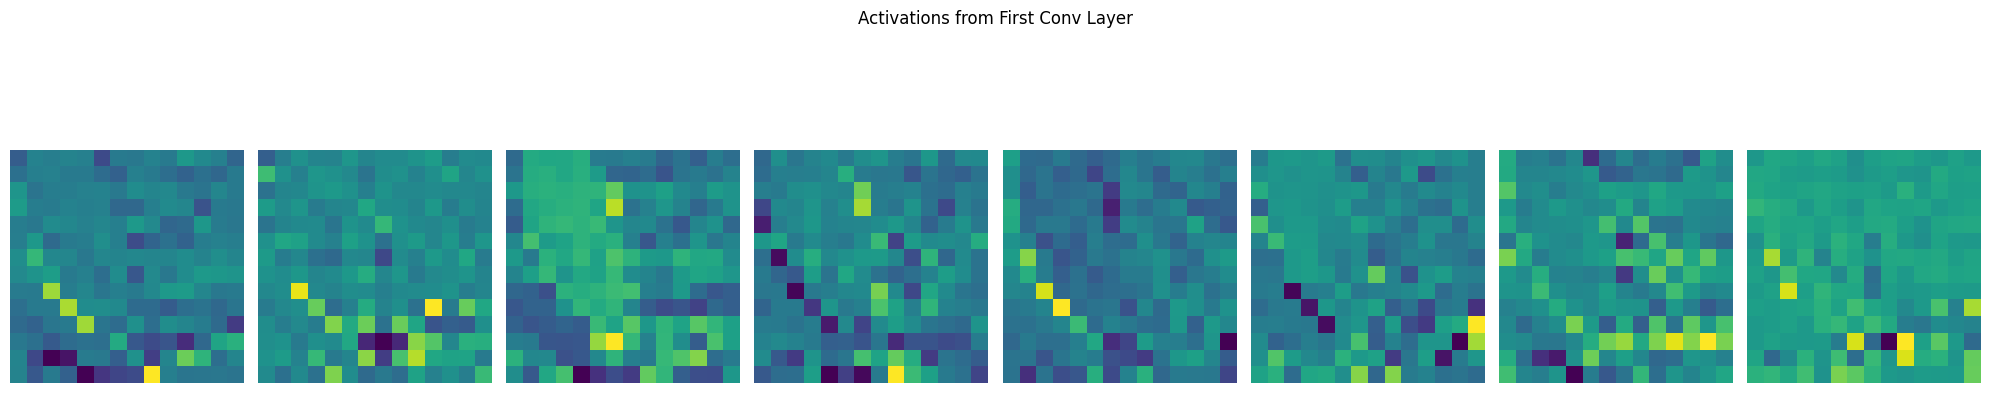

In [ ]:
class_names = ['Aphids', 'Healthy', 'Mitesthrips']  # Modify based on your dataset
framework_4.test(test_loader, class_names=class_names)

framework_4.visualize_first_layer_filters()

sample_image, _ = next(iter(test_loader))  # get a batch
framework_4.visualize_first_layer_activations(sample_image[0])  # visualize first image


**unfreeze 8 layers**

In [ ]:
# Replace with your model name and num_classes
model_name = 'vit_base_patch16_224'  # or any of the supported models
num_classes = 3
framework_5 = VisionTransformerFramework_fineTuned1(model_name=model_name, num_classes=num_classes)

Trainable params: 152


Epoch [1/30] Train Loss: 29.4195 Acc: 77.89% | Val Loss: 0.2175 Acc: 91.86%
Epoch [2/30] Train Loss: 6.0477 Acc: 96.46% | Val Loss: 0.3474 Acc: 85.50%
Epoch [3/30] Train Loss: 3.6614 Acc: 97.55% | Val Loss: 0.1721 Acc: 94.40%
Epoch [4/30] Train Loss: 0.3824 Acc: 99.84% | Val Loss: 0.1484 Acc: 95.17%
Epoch [5/30] Train Loss: 0.0590 Acc: 100.00% | Val Loss: 0.1590 Acc: 95.42%
Epoch [6/30] Train Loss: 0.0168 Acc: 100.00% | Val Loss: 0.1612 Acc: 95.42%
Epoch [7/30] Train Loss: 0.0118 Acc: 100.00% | Val Loss: 0.1631 Acc: 95.67%
Epoch [8/30] Train Loss: 0.0087 Acc: 100.00% | Val Loss: 0.1642 Acc: 95.67%
Epoch [9/30] Train Loss: 0.0070 Acc: 100.00% | Val Loss: 0.1656 Acc: 95.67%
Early stopping triggered.
Training complete in 847.14s


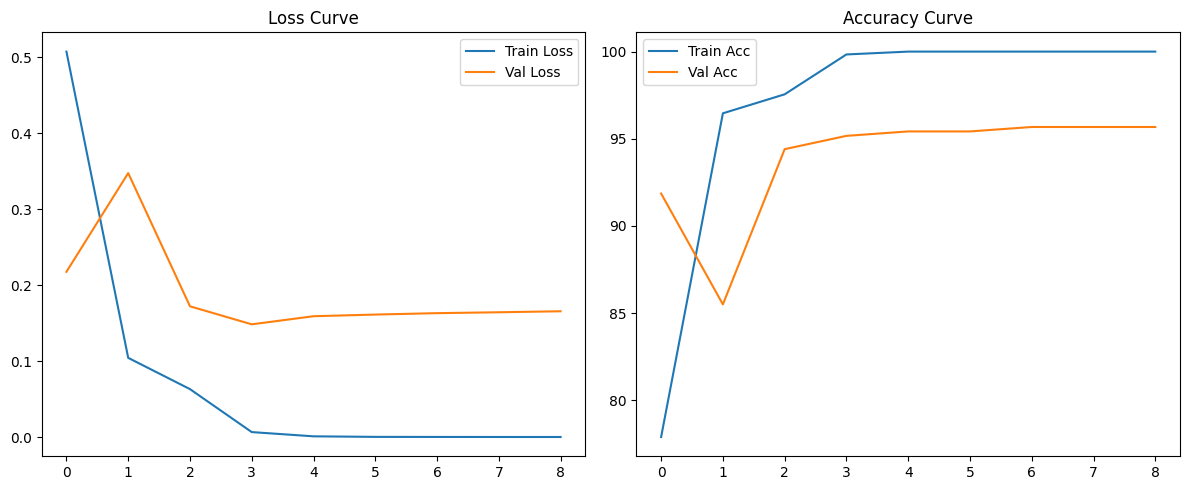

In [ ]:
framework_5.train(train_loader, val_loader, epochs=30, early_stopping_patience=5)

              precision    recall  f1-score   support

      Aphids       0.96      0.95      0.96       132
     Healthy       0.93      0.98      0.95       132
 Mitesthrips       0.97      0.92      0.95       132

    accuracy                           0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396



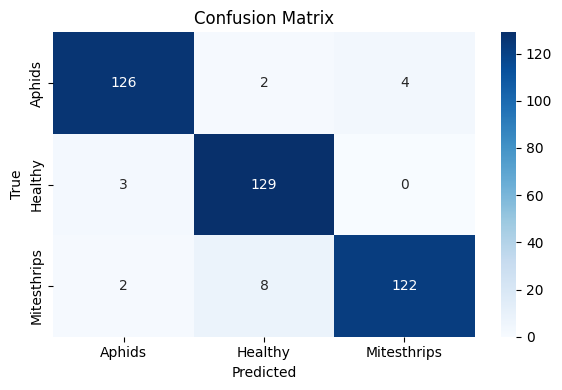

AUC Score: 0.9938


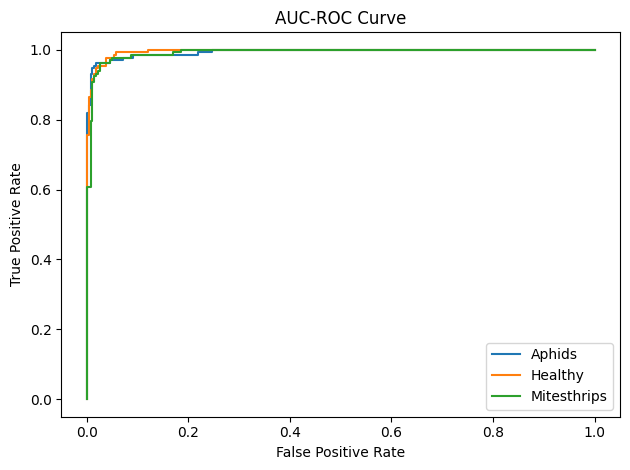

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


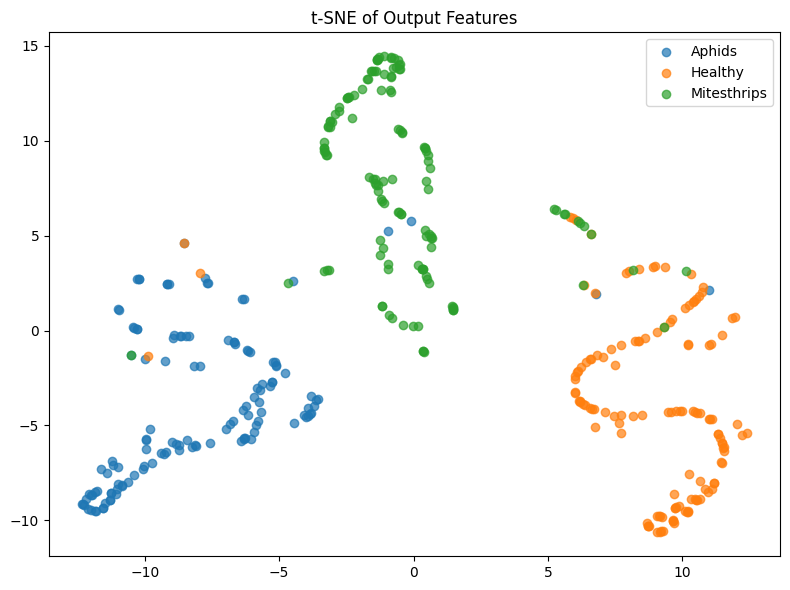

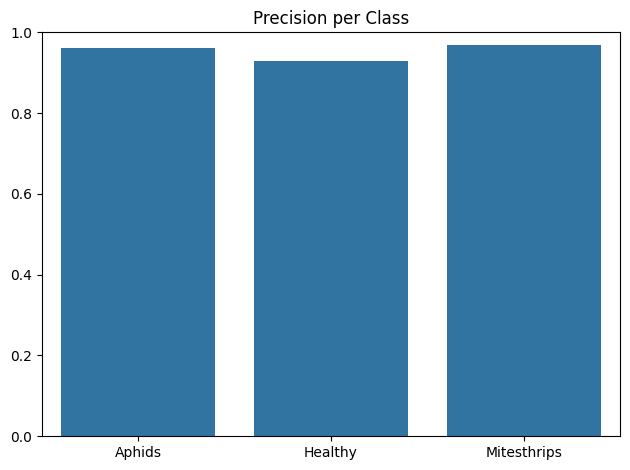

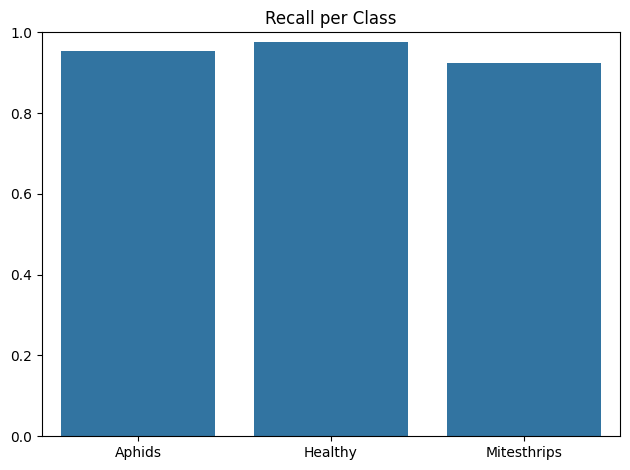

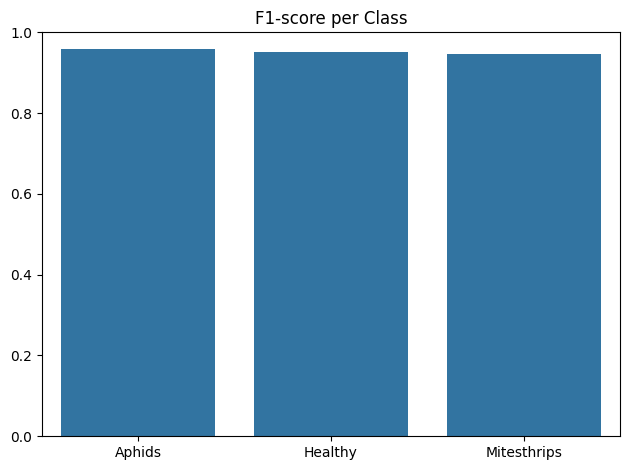

Test Accuracy: 95.20%


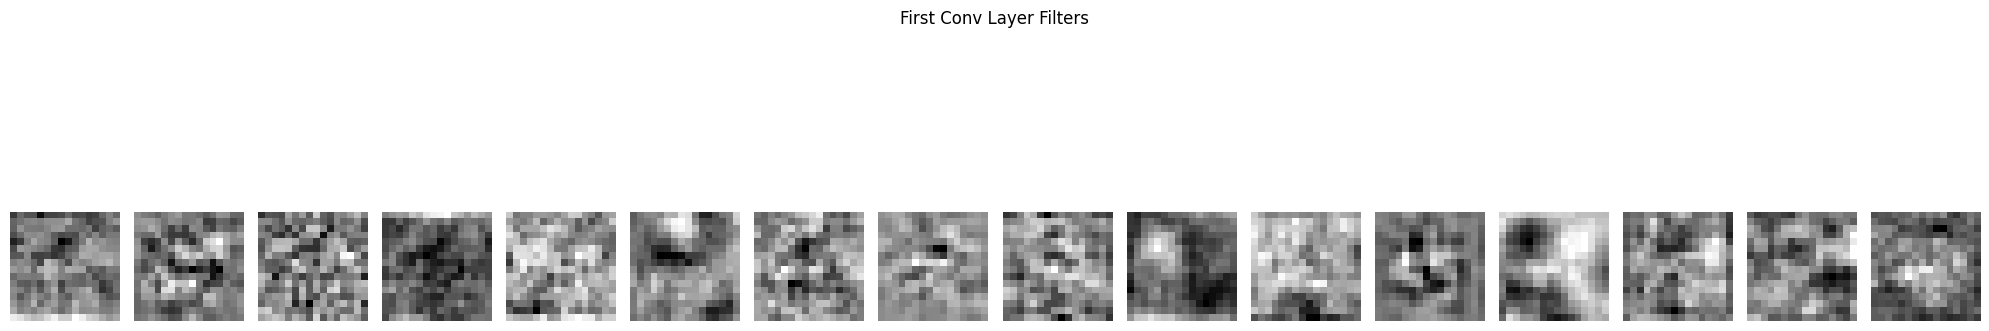

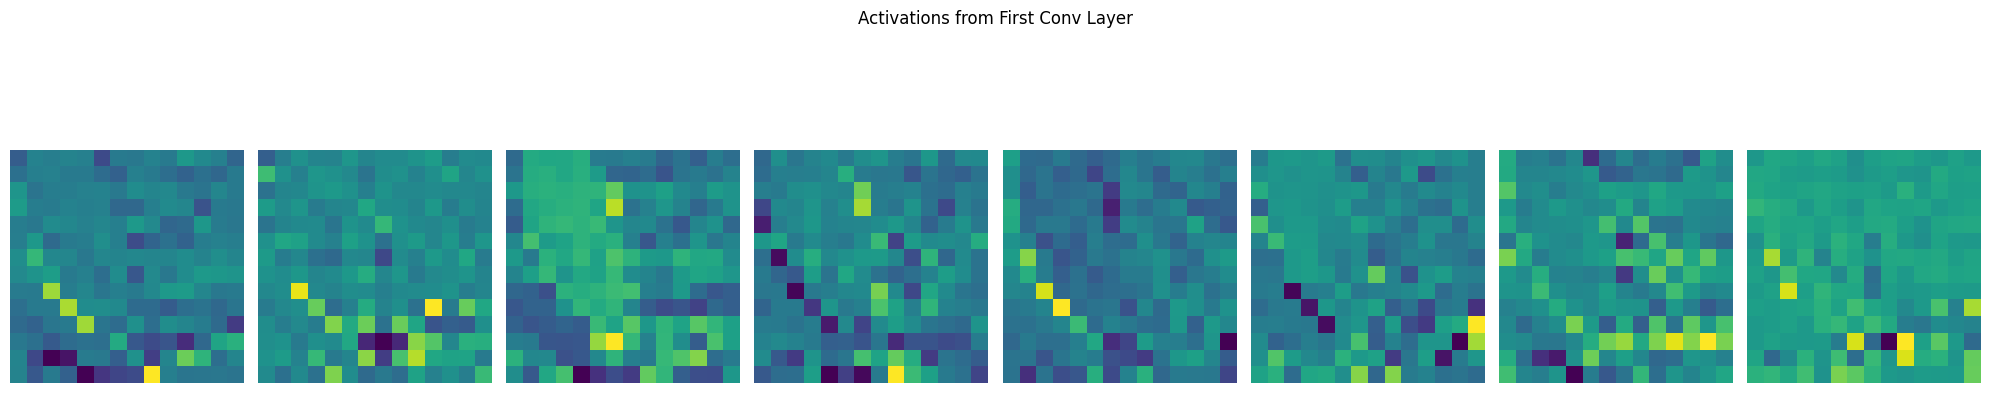

In [ ]:
class_names = ['Aphids', 'Healthy', 'Mitesthrips']  # Modify based on your dataset
framework_5.test(test_loader, class_names=class_names)

framework_5.visualize_first_layer_filters()

sample_image, _ = next(iter(test_loader))  # get a batch
framework_5.visualize_first_layer_activations(sample_image[0])  # visualize first image


**unfreeze 5 layers**

In [ ]:
# Replace with your model name and num_classes
model_name = 'vit_base_patch16_224'  # or any of the supported models
num_classes = 3
framework_6 = VisionTransformerFramework_fineTuned1(model_name=model_name, num_classes=num_classes)

Trainable params: 152


Epoch [1/30] Train Loss: 26.3431 Acc: 81.10% | Val Loss: 0.3326 Acc: 88.80%
Epoch [2/30] Train Loss: 6.2228 Acc: 96.46% | Val Loss: 0.1583 Acc: 94.15%
Epoch [3/30] Train Loss: 0.9797 Acc: 99.56% | Val Loss: 0.1872 Acc: 93.38%
Epoch [4/30] Train Loss: 0.3358 Acc: 99.78% | Val Loss: 0.1879 Acc: 93.64%
Epoch [5/30] Train Loss: 0.1917 Acc: 99.95% | Val Loss: 0.1893 Acc: 94.40%
Epoch [6/30] Train Loss: 0.0940 Acc: 99.95% | Val Loss: 0.1890 Acc: 94.91%
Epoch [7/30] Train Loss: 0.0970 Acc: 100.00% | Val Loss: 0.2026 Acc: 94.40%
Early stopping triggered.
Training complete in 649.82s


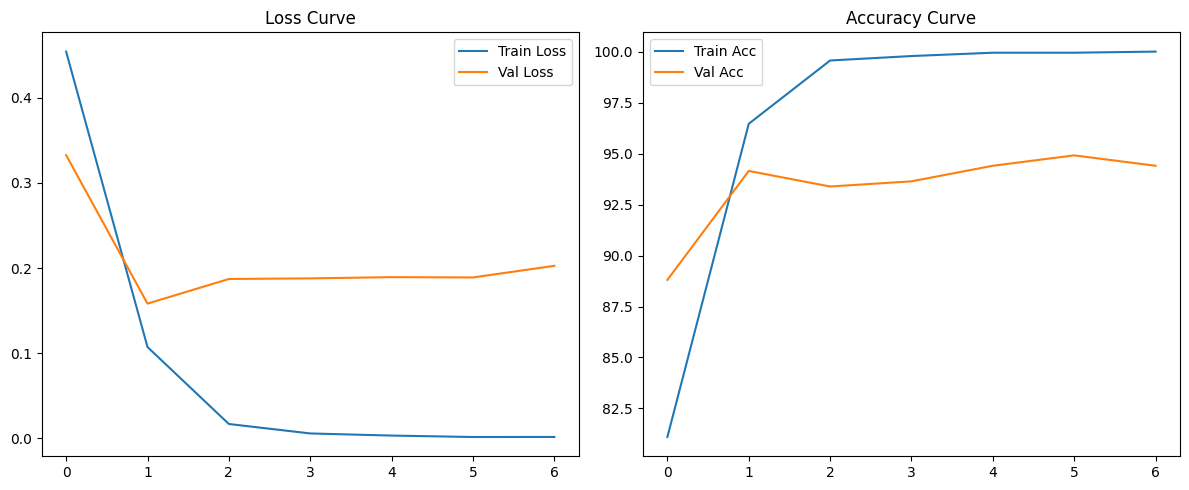

In [ ]:
framework_6.train(train_loader, val_loader, epochs=30, early_stopping_patience=5)

              precision    recall  f1-score   support

      Aphids       0.96      0.96      0.96       132
     Healthy       0.97      0.94      0.95       132
 Mitesthrips       0.93      0.95      0.94       132

    accuracy                           0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396



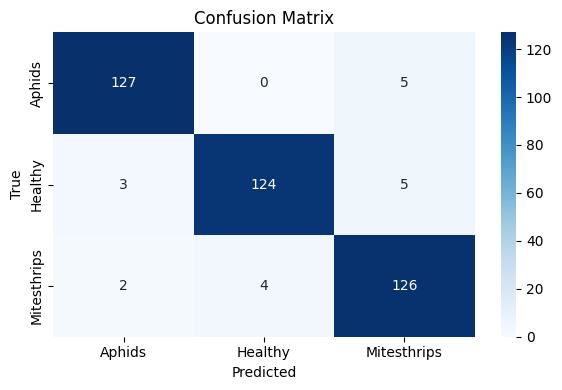

AUC Score: 0.9961


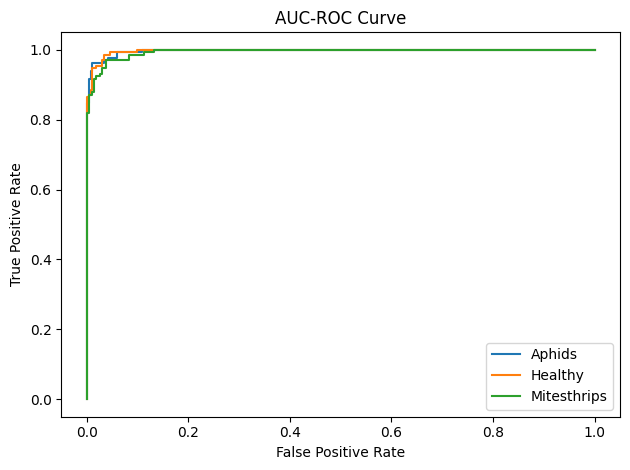

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


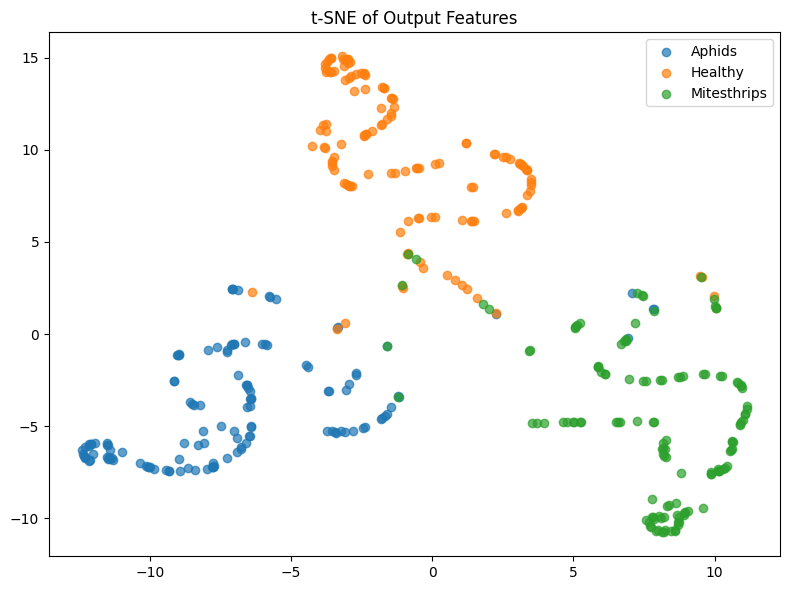

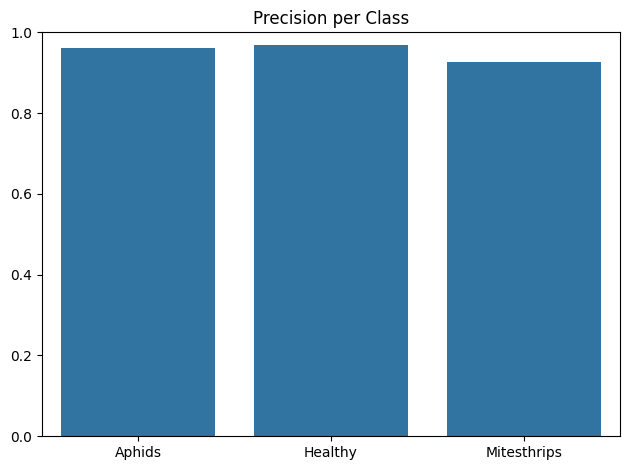

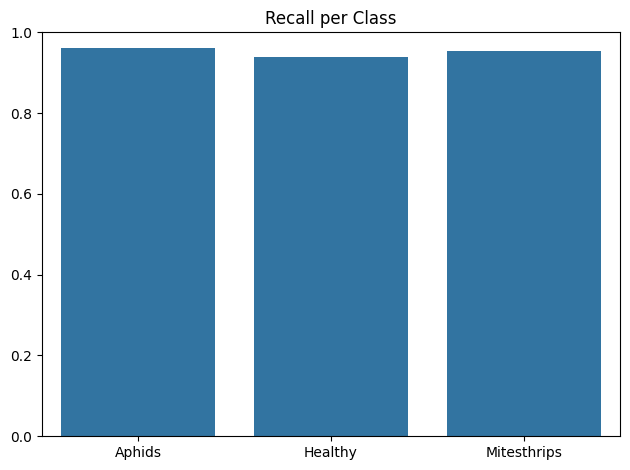

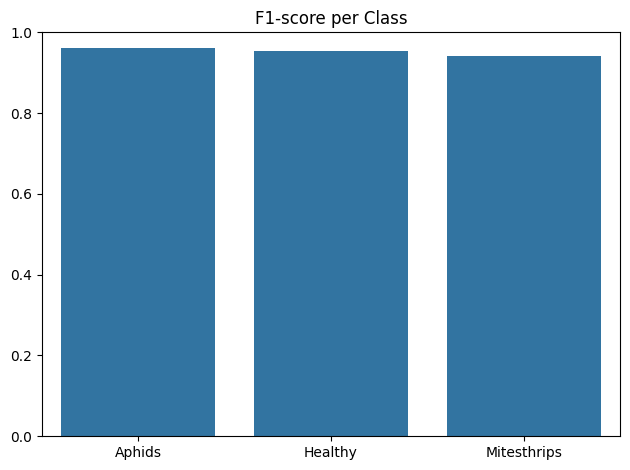

Test Accuracy: 95.20%


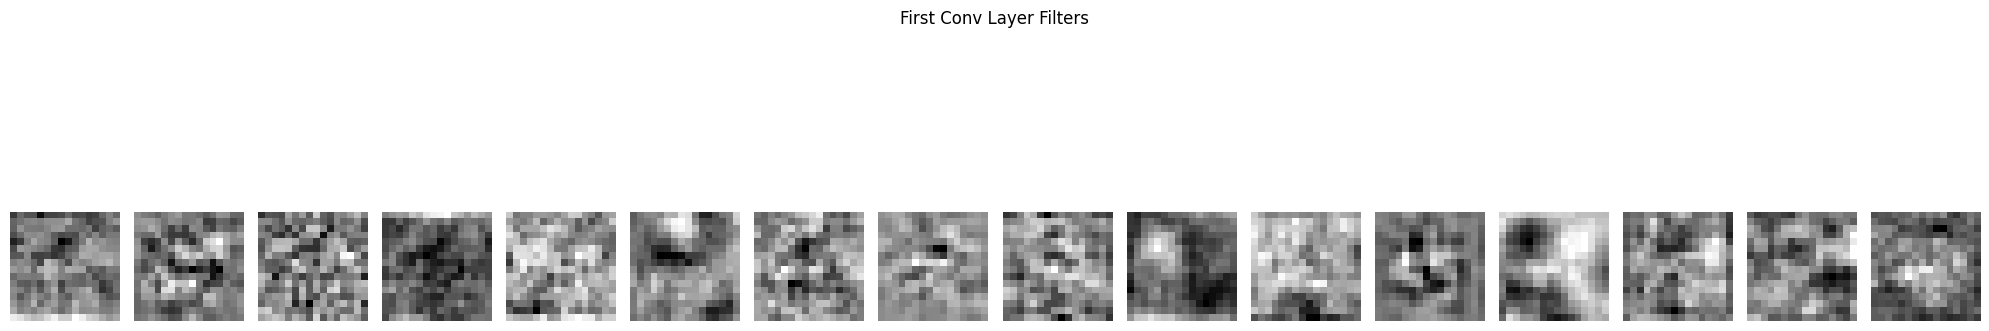

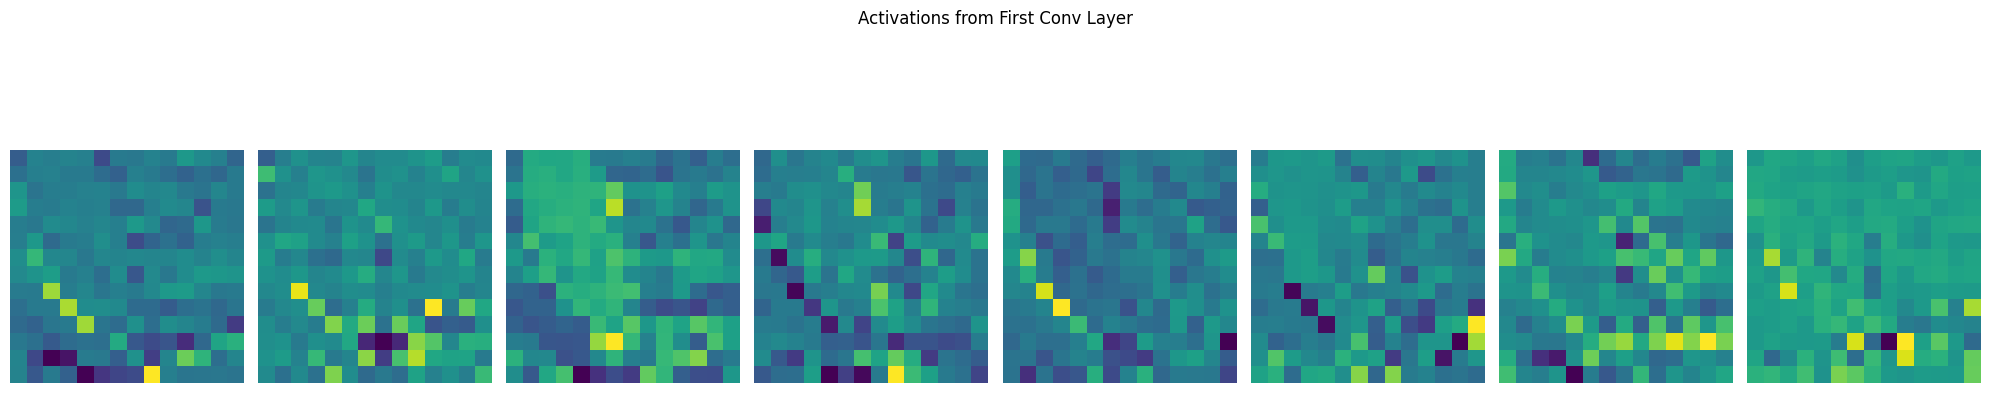

In [ ]:
class_names = ['Aphids', 'Healthy', 'Mitesthrips']  # Modify based on your dataset
framework_6.test(test_loader, class_names=class_names)

framework_6.visualize_first_layer_filters()

sample_image, _ = next(iter(test_loader))  # get a batch
framework_6.visualize_first_layer_activations(sample_image[0])  # visualize first image


**train only classifier head**

In [ ]:
# Replace with your model name and num_classes
model_name = 'vit_base_patch16_224'  # or any of the supported models
num_classes = 3
framework_7 = VisionTransformerFramework_fineTuned1(model_name=model_name, num_classes=num_classes)

Trainable params: 152


Epoch [1/30] Train Loss: 28.8650 Acc: 78.27% | Val Loss: 0.2368 Acc: 90.59%
Epoch [2/30] Train Loss: 7.3010 Acc: 96.24% | Val Loss: 0.1692 Acc: 93.38%
Epoch [3/30] Train Loss: 1.8891 Acc: 99.02% | Val Loss: 0.1767 Acc: 93.38%
Epoch [4/30] Train Loss: 0.1839 Acc: 100.00% | Val Loss: 0.1884 Acc: 92.62%
Epoch [5/30] Train Loss: 0.0581 Acc: 100.00% | Val Loss: 0.1983 Acc: 92.88%
Epoch [6/30] Train Loss: 0.0329 Acc: 100.00% | Val Loss: 0.2034 Acc: 92.88%
Epoch [7/30] Train Loss: 0.0236 Acc: 100.00% | Val Loss: 0.2092 Acc: 92.88%
Early stopping triggered.
Training complete in 617.83s


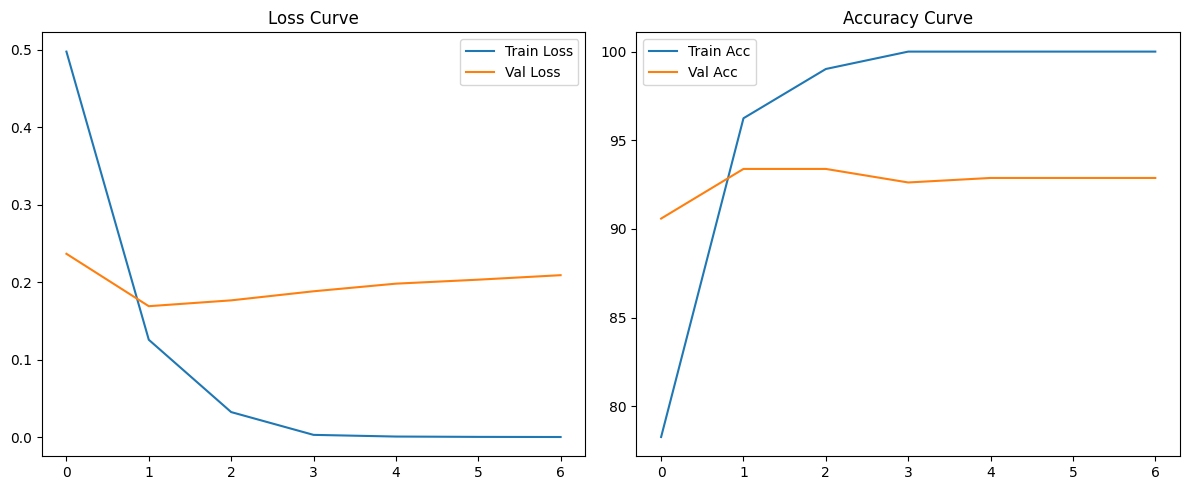

In [ ]:
framework_7.train(train_loader, val_loader, epochs=30, early_stopping_patience=5)

              precision    recall  f1-score   support

      Aphids       0.97      0.96      0.97       132
     Healthy       0.93      0.96      0.94       132
 Mitesthrips       0.95      0.92      0.94       132

    accuracy                           0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396



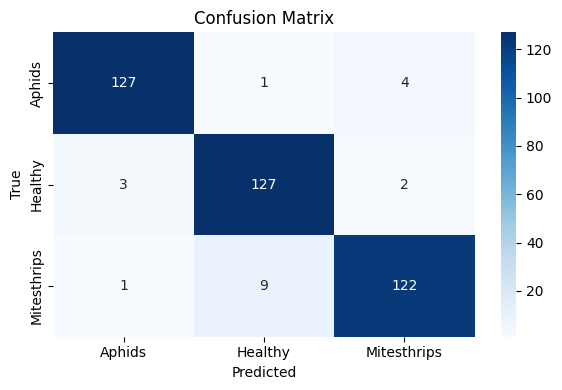

AUC Score: 0.9939


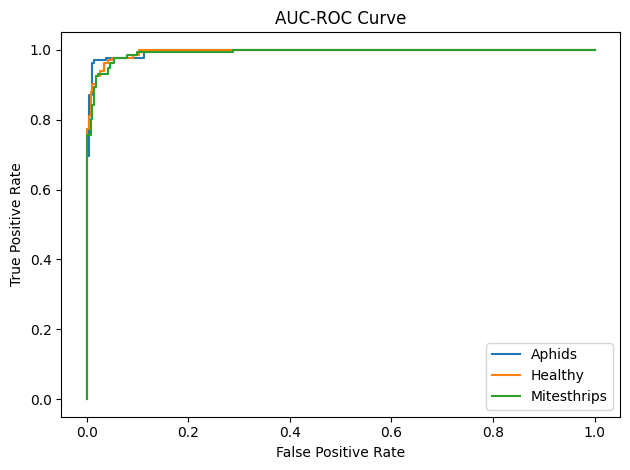

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


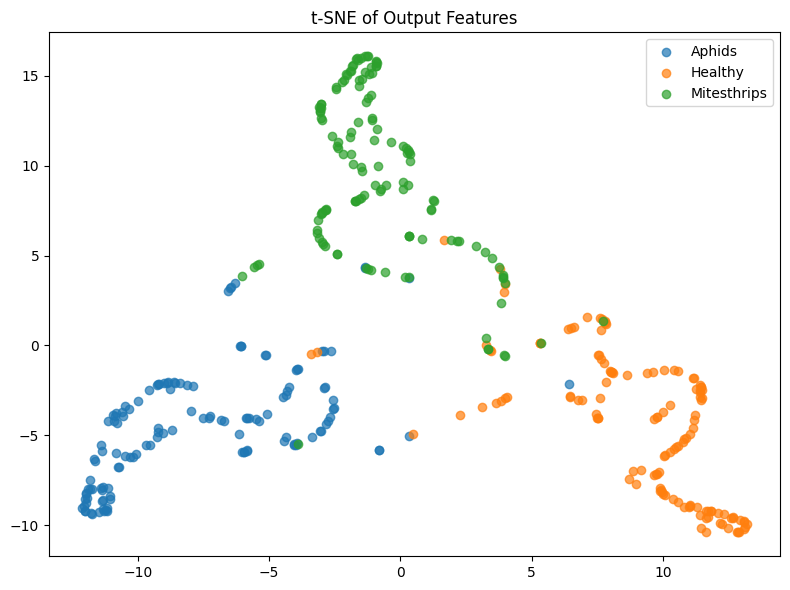

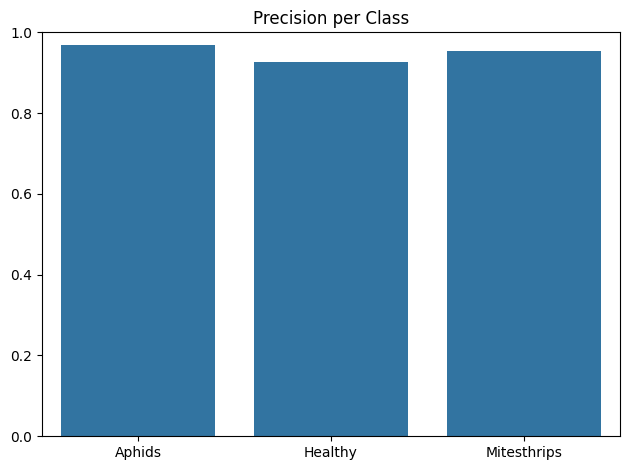

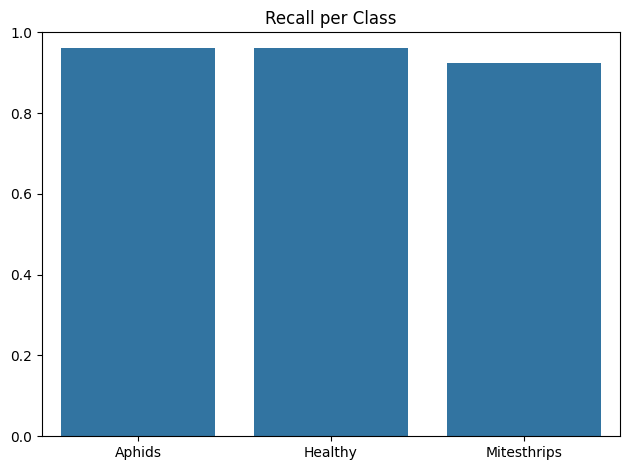

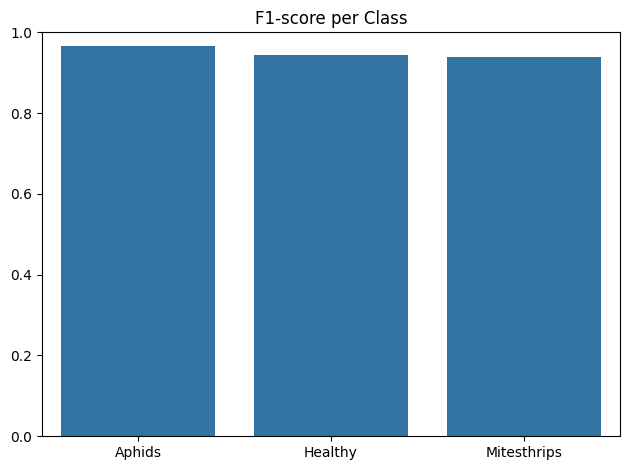

Test Accuracy: 94.95%


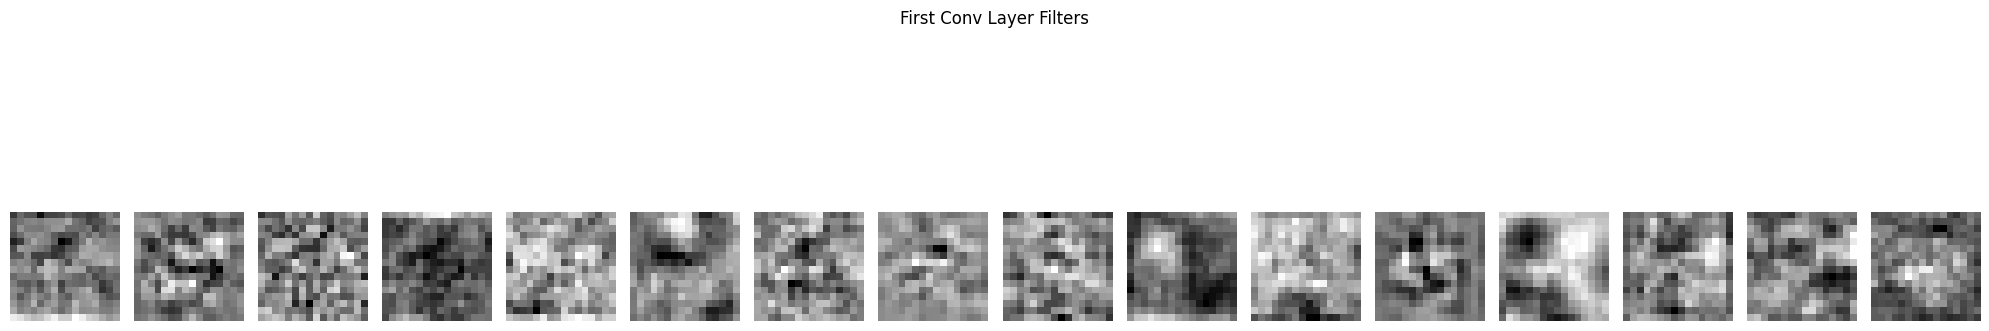

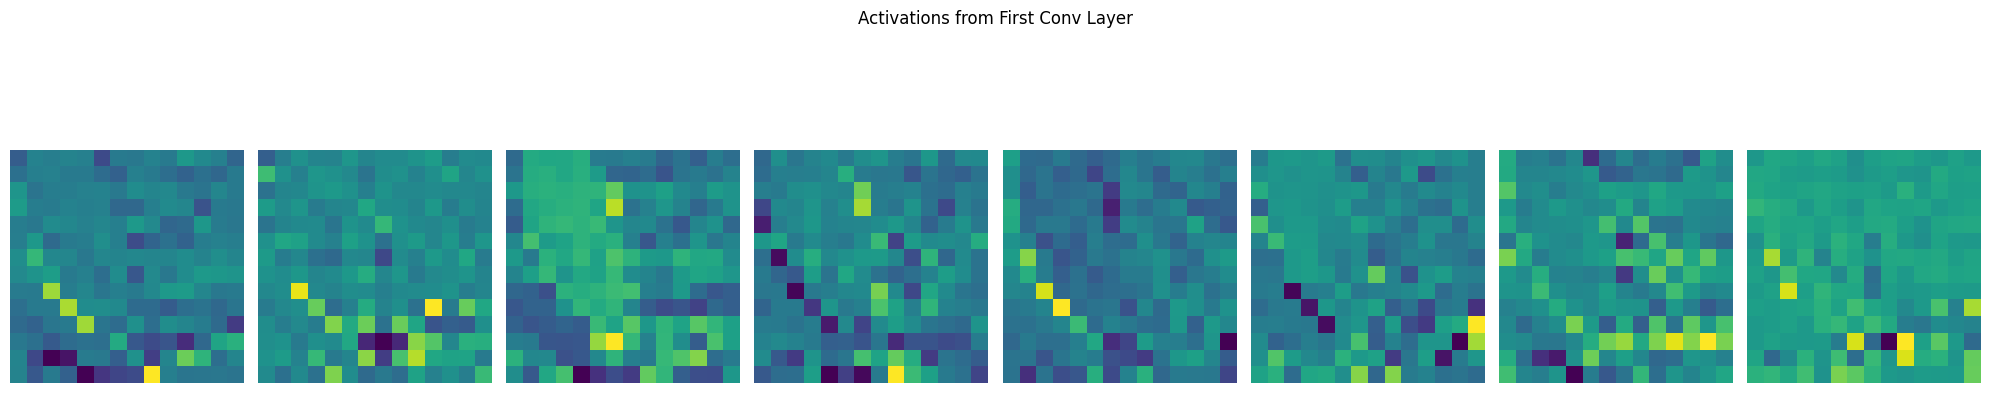

In [ ]:
class_names = ['Aphids', 'Healthy', 'Mitesthrips']  # Modify based on your dataset
framework_7.test(test_loader, class_names=class_names)

framework_7.visualize_first_layer_filters()

sample_image, _ = next(iter(test_loader))  # get a batch
framework_7.visualize_first_layer_activations(sample_image[0])  # visualize first image


In [ ]:
import torch
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder('/content/DatasetB_split_zip/val', transform=val_test_transform)
test_dataset = datasets.ImageFolder('/content/DatasetB_split_zip/test', transform=val_test_transform)


# Example dataset path (use your own)
train_dataset = datasets.ImageFolder('/content/DatasetB_split_zip/train', transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Class names
class_names = train_dataset.classes

In [ ]:
# Replace with your model name and num_classes
model_name = 'vit_base_patch16_224'  # or any of the supported models
num_classes = 3
framework = VisionTransformerFramework_fineTuned1(model_name=model_name, num_classes=num_classes)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Trainable params: 152


Epoch [1/30] Train Loss: 25.4360 Acc: 82.79% | Val Loss: 0.2666 Acc: 88.80%
Epoch [2/30] Train Loss: 10.6156 Acc: 93.74% | Val Loss: 0.2412 Acc: 90.33%
Epoch [3/30] Train Loss: 6.5918 Acc: 95.81% | Val Loss: 0.3293 Acc: 88.55%
Epoch [4/30] Train Loss: 4.9425 Acc: 96.46% | Val Loss: 0.2803 Acc: 91.35%
Epoch [5/30] Train Loss: 2.0640 Acc: 98.75% | Val Loss: 0.1850 Acc: 93.38%
Epoch [6/30] Train Loss: 1.8955 Acc: 98.80% | Val Loss: 0.1469 Acc: 95.17%
Epoch [7/30] Train Loss: 0.9882 Acc: 99.46% | Val Loss: 0.3136 Acc: 92.62%
Epoch [8/30] Train Loss: 3.3585 Acc: 98.26% | Val Loss: 0.1387 Acc: 94.66%
Epoch [9/30] Train Loss: 1.1607 Acc: 99.24% | Val Loss: 0.1403 Acc: 94.40%
Epoch [10/30] Train Loss: 0.3512 Acc: 99.78% | Val Loss: 0.2024 Acc: 94.40%
Epoch [11/30] Train Loss: 0.2512 Acc: 99.95% | Val Loss: 0.2281 Acc: 93.64%
Epoch [12/30] Train Loss: 0.2351 Acc: 99.89% | Val Loss: 0.2272 Acc: 94.15%
Epoch [13/30] Train Loss: 0.0922 Acc: 100.00% | Val Loss: 0.2168 Acc: 94.91%
Early stopping tri

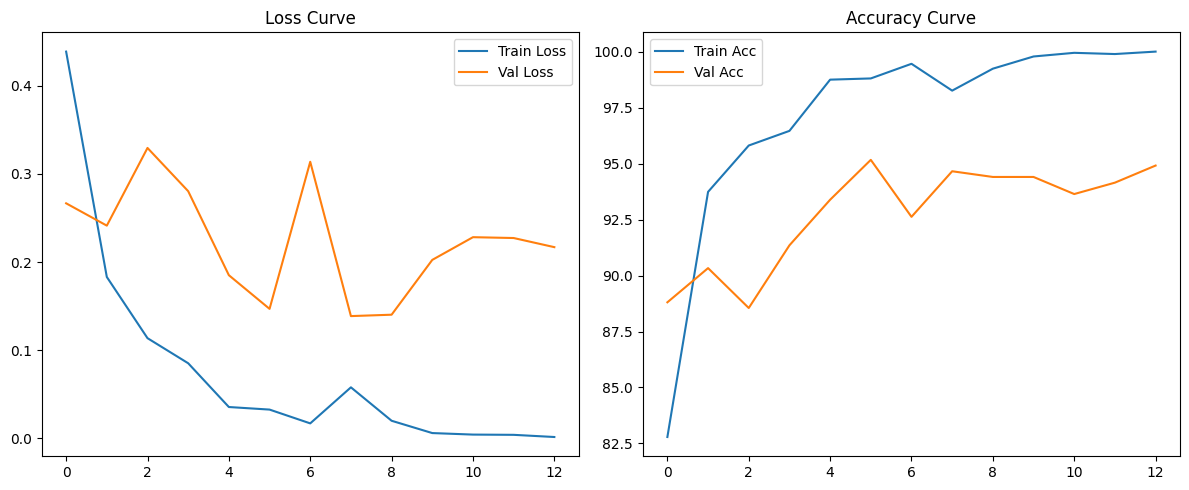

In [ ]:
framework.train(train_loader, val_loader, epochs=30, early_stopping_patience=5)

              precision    recall  f1-score   support

      Aphids       0.98      0.97      0.97       132
     Healthy       0.92      1.00      0.96       132
 Mitesthrips       0.98      0.89      0.93       132

    accuracy                           0.95       396
   macro avg       0.96      0.95      0.95       396
weighted avg       0.96      0.95      0.95       396



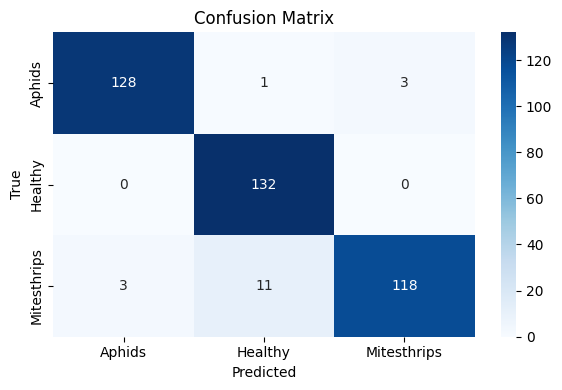

AUC Score: 0.9950


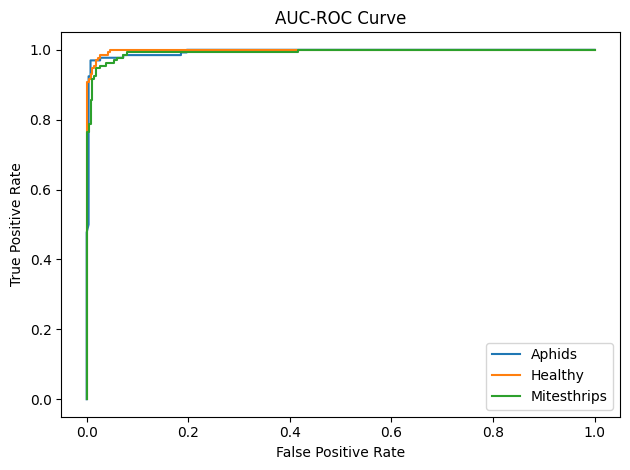

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


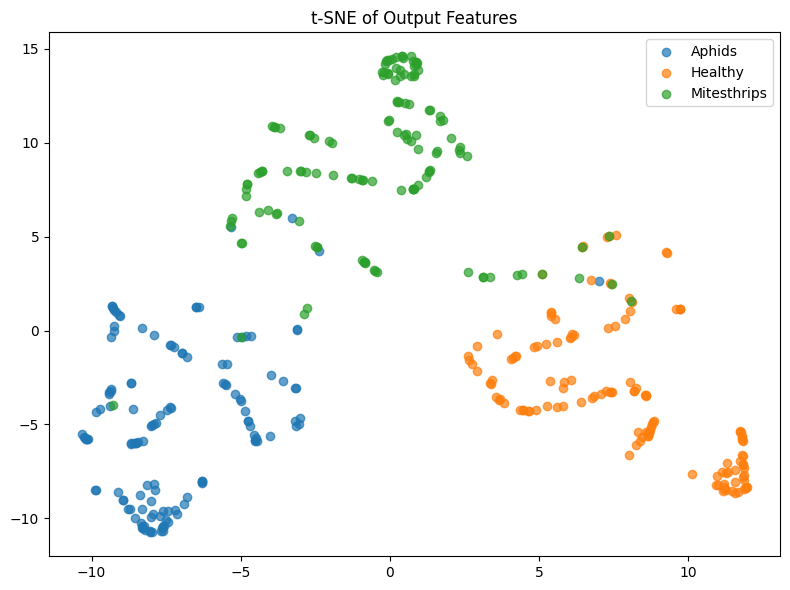

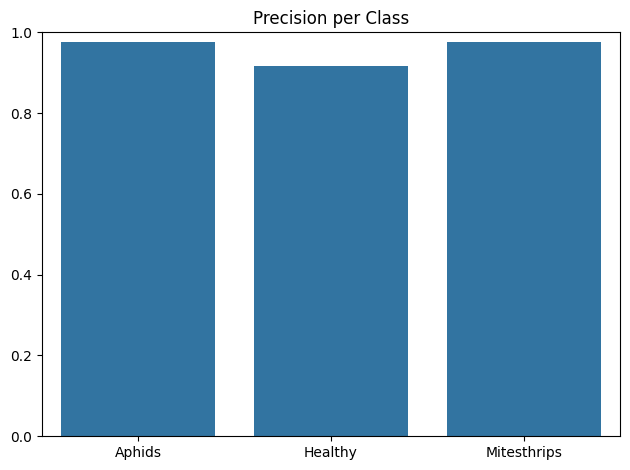

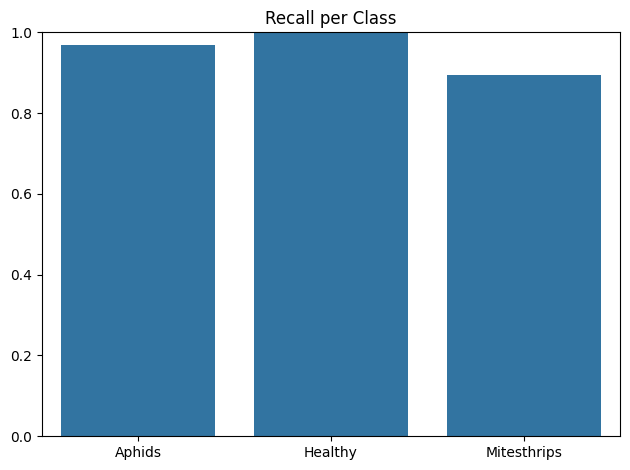

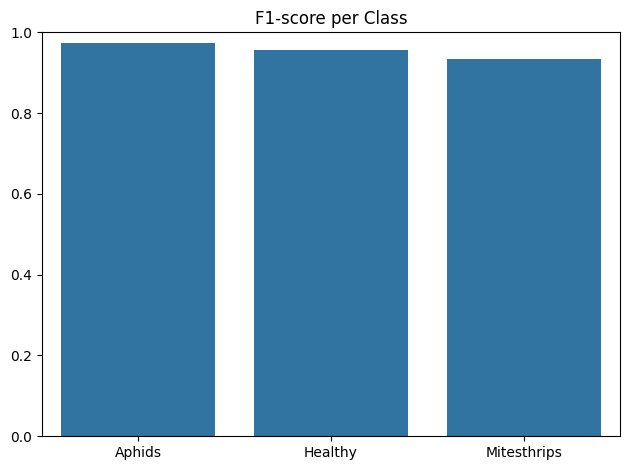

Test Accuracy: 95.45%


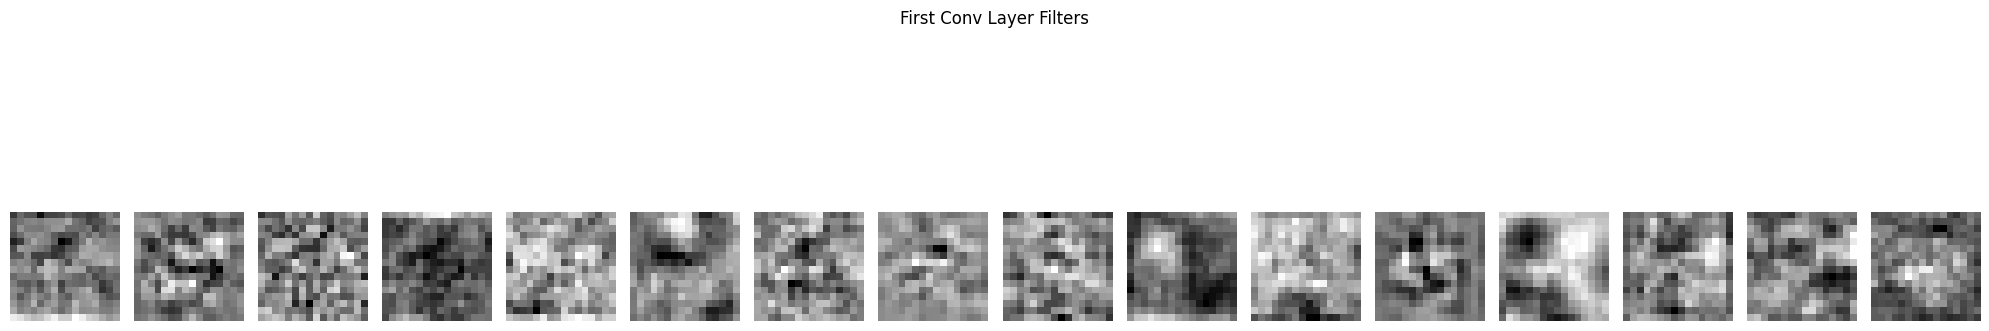

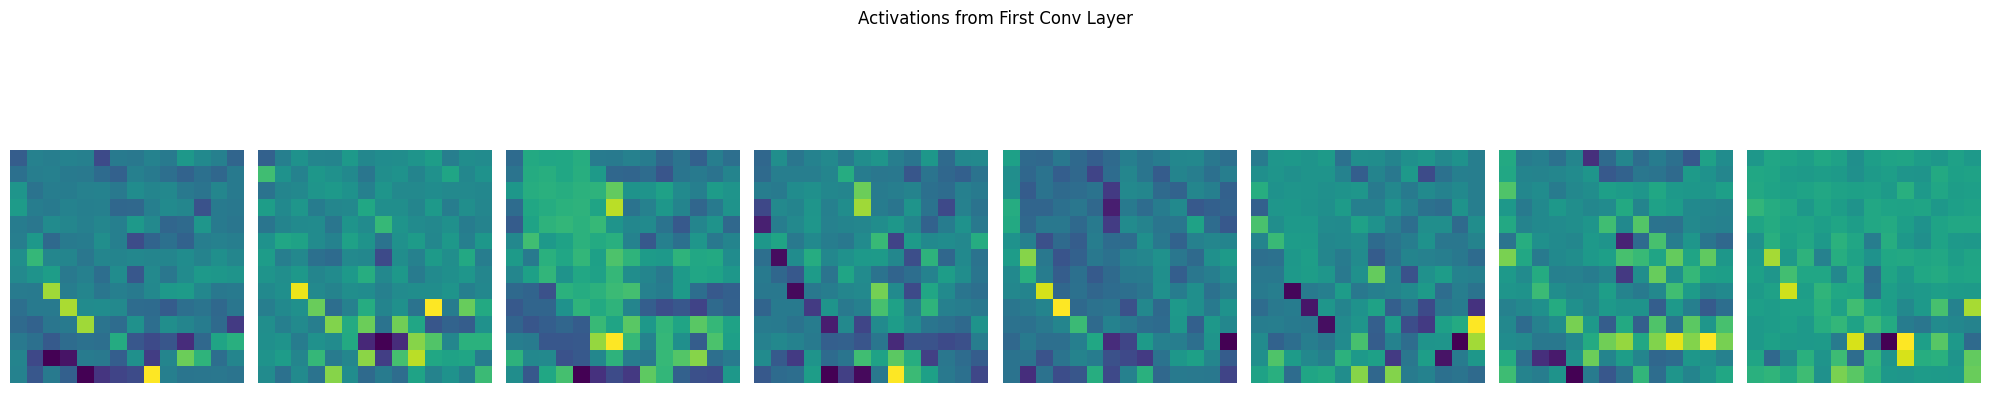

In [ ]:
class_names = ['Aphids', 'Healthy', 'Mitesthrips']  # Modify based on your dataset
framework.test(test_loader, class_names=class_names)

framework.visualize_first_layer_filters()

sample_image, _ = next(iter(test_loader))  # get a batch
framework.visualize_first_layer_activations(sample_image[0])  # visualize first image


In [2]:
!pip install nbstripout


Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
